In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# from data_load import *
# from model_fit_functions import *

from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import copy


In [2]:
from data_load import load_split_pool
from model_fit_functions import plot_coefs_vs_wavelength, numpy_rolling_mean, calculate_std_abs_loadings, rescale_back
from model_fit_functions import compare_distances_pca, calculate_reconstr_loss_pca_2

In [3]:
# Load data
data_dict =  load_split_pool(1346, 430, 10, scale = True)

# Pooled X data
train_df_pooled = data_dict["x_pooled"]["train"]
val_df_pooled = data_dict["x_pooled"]["val"]

Directory: Complete_Spectral_Data\Training_Data Physical properties shape: (1346, 5) Spectral prop shape: (1346, 110001)
Directory: Complete_Spectral_Data\Test_Data Physical properties shape: (810, 5) Spectral prop shape: (810, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


# PCA

In [8]:
# Initialsie dictionary for storing results
pca_results_dict = dict()

# Create a sub-dictionary to store results specific for a given choice of n_comp
pca_results_dict["restricted_spaces"] = dict()

# different number of components to consider
n_comp_list = list( np.arange(2, 100, 2) )

# Fit PCA

pca = PCA(n_components=250)
pca.fit(train_df_pooled)
# transform train set
x_train_pca = pca.transform(train_df_pooled)
# transform val set
x_val_pca = pca.transform(val_df_pooled)


# Store main results, common to all choices of n_comp
pca_results_dict["object"] = pca
pca_results_dict["x_train_input"] = train_df_pooled
pca_results_dict["x_val_input"] = val_df_pooled

# dict for trimmed pca:
pca_trim_results_dict = copy.deepcopy(pca_results_dict) # use deep copy to copy sub-elements

In [10]:
# Caluclate PCA reconstruction loss and distances
trim = False

# iterate over different choices of n_comp
for n_comp in n_comp_list:
    
    pca_results_dict["restricted_spaces"][n_comp] = dict()
    
#     x_val_pca, x_val_original_space_pca, loss = pca_projections_and_lossses( val_df_pooled, pca, n_comp)
    x_val_pca, x_val_original_space_pca, loss = calculate_reconstr_loss_pca_2(pca, val_df_pooled, n_comp, 
                                                                               trim = trim, rescale = True, 
                                                                               mean = data_dict["parameters"]["mean"], std =  data_dict["parameters"]["std"])


    dist_ratios_mean, dist_ratios_std = compare_distances_pca(val_df_pooled, x_val_pca)

        
    pca_results_dict["restricted_spaces"][n_comp]["distances_mean"] = dist_ratios_mean
    pca_results_dict["restricted_spaces"][n_comp]["distances_std"] = dist_ratios_std
#     pca_results_dict["restricted_spaces"][n_comp]["x_val_transformed"] = x_val_pca
#     pca_results_dict["restricted_spaces"][n_comp]["x_val_original_space_pca"] = x_val_original_space_pca
    pca_results_dict["restricted_spaces"][n_comp]["loss"] = loss
    
    if n_comp == 50:
        pca_results_dict["restricted_spaces"][n_comp]["x_val_transformed"] = x_val_pca
        pca_results_dict["restricted_spaces"][n_comp]["x_val_original_space_pca"] = x_val_original_space_pca
    


In [11]:
# Caluclate PCA (trimmed) reconstruction loss and distances
trim = True


# iterate over different choices of n_comp
for n_comp in n_comp_list:
    
    pca_trim_results_dict["restricted_spaces"][n_comp] = dict()
    
#     x_val_pca, x_val_original_space_pca, loss = pca_projections_and_lossses( val_df_pooled, pca, n_comp)
    x_val_pca, x_val_original_space_pca, loss = calculate_reconstr_loss_pca_2(pca, val_df_pooled, n_comp, 
                                                                               trim = trim, rescale = True, 
                                                                               mean = data_dict["parameters"]["mean"], std =  data_dict["parameters"]["std"])


    dist_ratios_mean, dist_ratios_std = compare_distances_pca(val_df_pooled, x_val_pca)

        
    pca_trim_results_dict["restricted_spaces"][n_comp]["distances_mean"] = dist_ratios_mean
    pca_trim_results_dict["restricted_spaces"][n_comp]["distances_std"] = dist_ratios_std
#     pca_trim_results_dict["restricted_spaces"][n_comp]["x_val_transformed"] = x_val_pca
#     pca_trim_results_dict["restricted_spaces"][n_comp]["x_val_original_space_pca"] = x_val_original_space_pca
    pca_trim_results_dict["restricted_spaces"][n_comp]["loss"] = loss
    
    if n_comp == 50:
        pca_trim_results_dict["restricted_spaces"][n_comp]["x_val_transformed"] = x_val_pca
        pca_trim_results_dict["restricted_spaces"][n_comp]["x_val_original_space_pca"] = x_val_original_space_pca
    

In [13]:
pca = pca_results_dict.copy()

# ((pca['restricted_spaces'][6]['x_val_transformed'] - pca['restricted_spaces'][6]['x_val_original_space_pca'])**2).sum().sum()/pca['restricted_spaces'][50]['x_val_transformed'].size

In [ ]:
dump_object("pca", pca_results_dict)
dump_object("pca_trim", pca_trim_results_dict)

# Reconstruction loss

In [14]:
pca_loss = [ pca_results_dict["restricted_spaces"][i]["loss"] for i in pca_results_dict["restricted_spaces"] ]
pca_trim_loss = [ pca_trim_results_dict["restricted_spaces"][i]["loss"] for i in pca_trim_results_dict["restricted_spaces"] ]

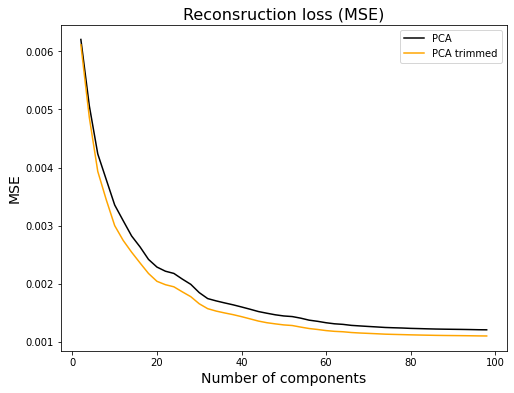

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8,6))
ax.plot( np.array(n_comp_list), np.array(pca_loss) , label = "PCA", color = "black")
ax.plot( np.array(n_comp_list), np.array(pca_trim_loss) , label = "PCA trimmed", color = "orange")

ax.legend()
ax.set_title("Reconsruction loss (MSE)", fontsize = 16)
ax.set_ylabel("MSE", fontsize = 14)
ax.set_xlabel("Number of components", fontsize = 14);

# Appendix

The analysis below is included in "analysis" notebooks. I put it here just for an illustration, but it can be skipped or deleted 

In [16]:
pca = pca_results_dict.copy()

## A1: Distance preservation

In [17]:
# Extract distances from the dictionary

dist_ratios_mean = [ pca_results_dict["restricted_spaces"][i]["distances_mean"] for i in pca_results_dict["restricted_spaces"] ]
dist_ratios_std = [ pca_results_dict["restricted_spaces"][i]["distances_std"] for i in pca_results_dict["restricted_spaces"] ]

dist_ratios_mean = np.array( dist_ratios_mean )
dist_ratios_std = np.array( dist_ratios_std )

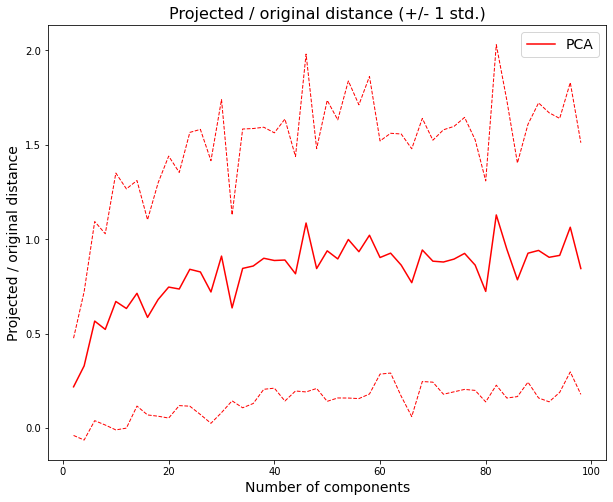

In [18]:
# Compare distance preservation between random projections and PCA 

fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(np.array(n_comp_list), dist_ratios_mean,
        color = "red", label = "PCA" )
ax.plot(np.array(n_comp_list), dist_ratios_mean - dist_ratios_std,
        color = "red", linestyle = "--", linewidth = '1' )
ax.plot(np.array(n_comp_list), dist_ratios_mean + dist_ratios_std,
       color = "red", linestyle = "--", linewidth = '1' )
ax.set_title("Projected / original distance (+/- 1 std.)", fontsize = 16)
ax.set_ylabel("Projected / original distance", fontsize = 14)
ax.set_xlabel("Number of components", fontsize = 14);

ax.legend(fontsize = 14);

## A2: PCA Loadings

In [20]:
# Calculate loadings of 1 st component, then of components 1 to 5, etc
comp_numbers_list = [0, 1, 5, 10, 50]
loadings_pca = [calculate_std_abs_loadings(pca["object"].components_, comp_numbers_list[n], comp_numbers_list[n+1]
                                          ) for n in range(len(comp_numbers_list)-1)]

0
1
2
3


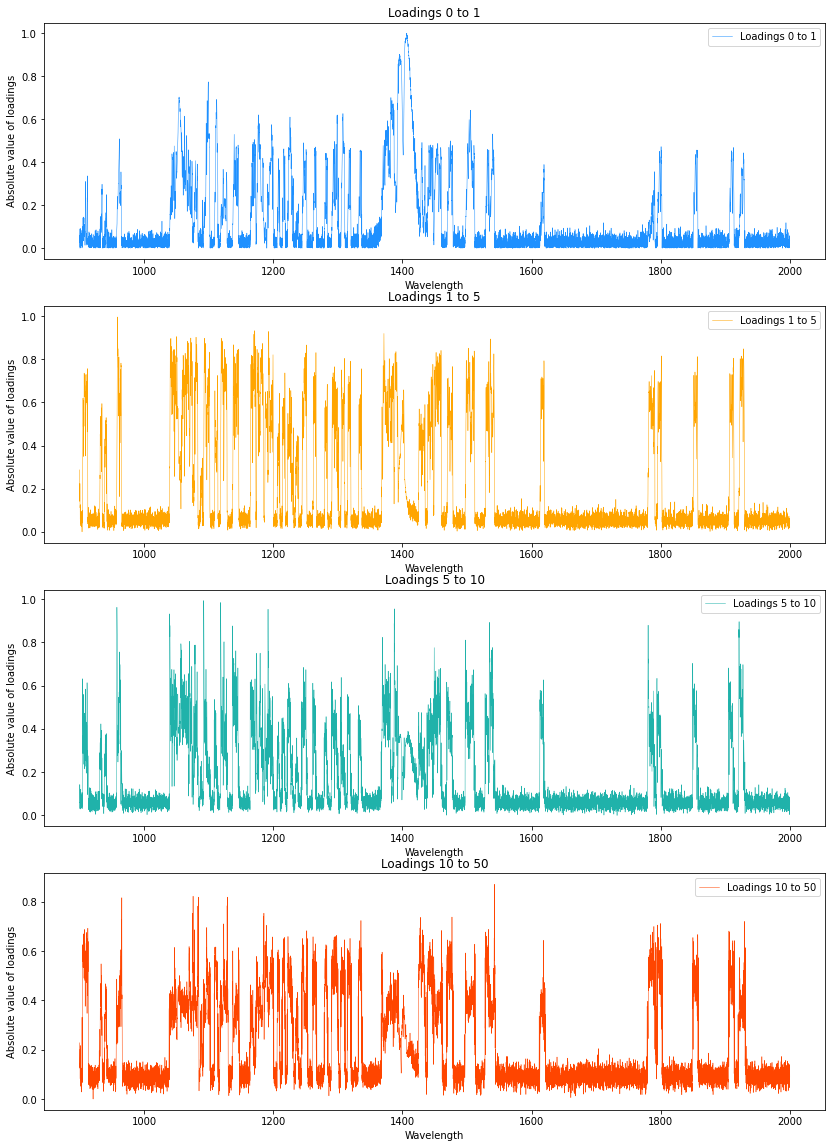

In [21]:
import matplotlib.pyplot as plt


plt, ax = plt.subplots(4, 1, figsize = (14, 20))

colors = ["dodgerblue", "orange", "lightseagreen", "orangered"]

i = 0
for loadings, loadings_num in zip(loadings_pca, comp_numbers_list[:-1]):
    plot_label = "Loadings " + str(comp_numbers_list[i]) + " to " + str(comp_numbers_list[i+1])
    print(i)
    ax[i].plot(data_dict["wavelengths"], loadings, label = plot_label, linewidth = 0.5, color = colors[i])
    ax[i].legend()
    ax[i].set_title(plot_label)
    ax[i].set_ylabel("Absolute value of loadings")
    ax[i].set_xlabel("Wavelength")
    
    i += 1



Text(0.5, 1.0, 'Absolute value of loadings (standardized) PCA')

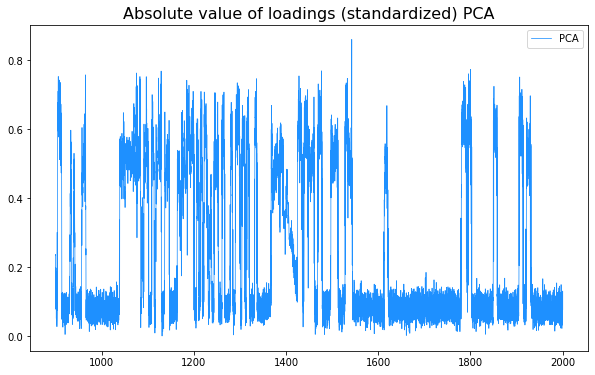

In [22]:

import matplotlib.pyplot as plt

pca_top50 = calculate_std_abs_loadings(pca["object"].components_, 0, 50)

fig, ax = plt.subplots(figsize = (10, 6), sharex = True)

ax.plot( data_dict["wavelengths"], pca_top50, label = "PCA", linewidth = 0.75, color = "dodgerblue" )
ax.legend()
ax.set_title("Absolute value of loadings (standardized) PCA", fontsize = 16)

## A3: Signal reconstruction

In [23]:
# use treimmed PCA
trim = True

In [24]:
random.seed(6541)
number_of_elements = 50
random_number_list = random.sample(range(val_df_pooled.shape[0]), number_of_elements)
# number_of_elements = 50

print("Sample: ", np.array( random_number_list ) )

Sample:  [248 345 135  42 388 303 126  53 411 384 332  80 397 273 405 369 185 244
 288 189 309 416 216 197 287 247 315  49   5 125 227 228 155 235  67 222
  25 112 264 250 372 108 269  41  87 414  36 182 359 398]


In [25]:
_, obs_projected_pca_2, _ = calculate_reconstr_loss_pca_2(pca["object"], val_df_pooled, n_comp, 
                                                                               trim = trim, rescale = True, 
                                                                               mean = data_dict["parameters"]["mean"], std =  data_dict["parameters"]["std"])
# obs_projected_pca_2 = obs_projected_pca_2.to_numpy()[random_number_list,:]

# Convert val set to the original scale
val_df_pooled_rescaled = rescale_back(val_df_pooled.to_numpy(), 
                             data_dict["parameters"]["mean"], 
                             data_dict["parameters"]["std"])


<ipython-input-41-4535ab580040>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, 1, sharex = True, figsize = (16, 14))


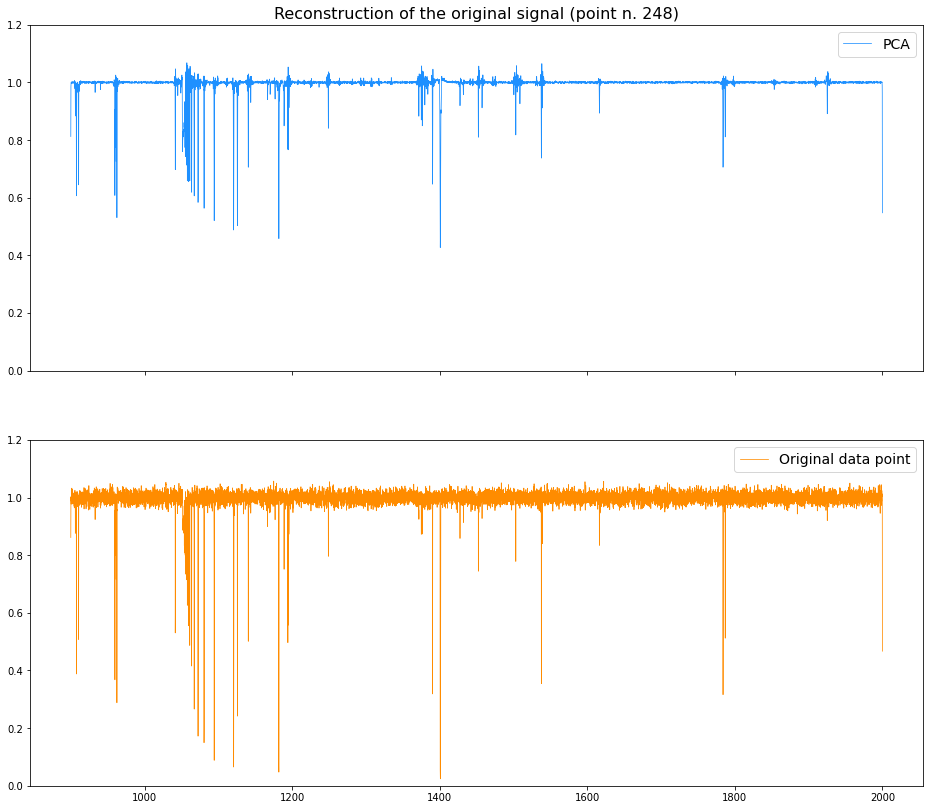

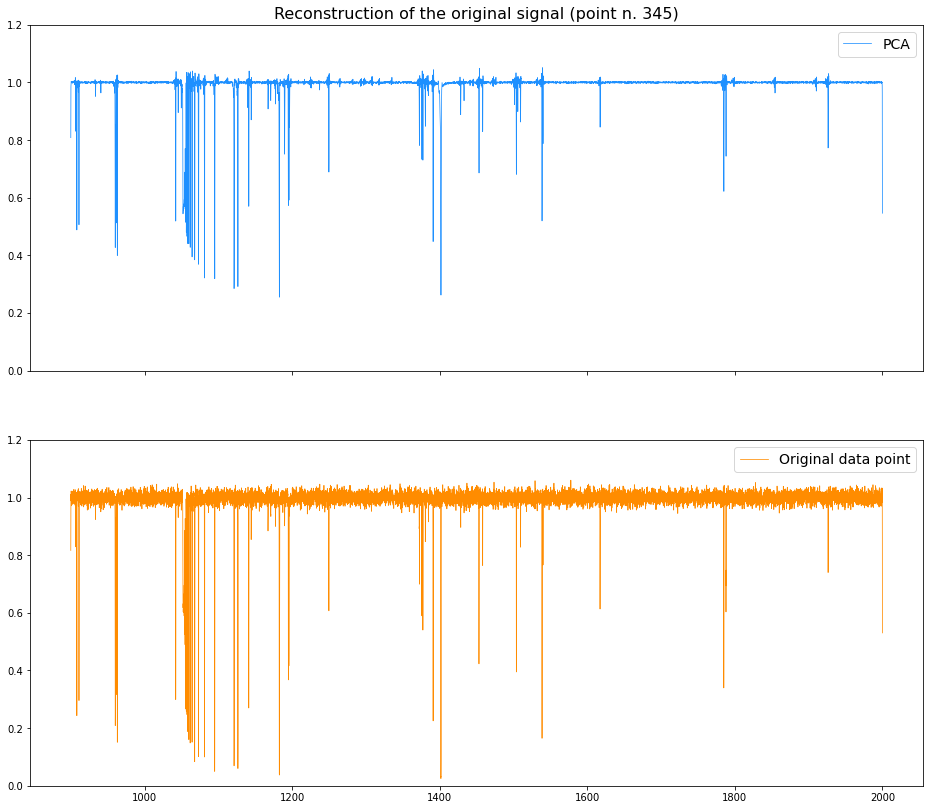

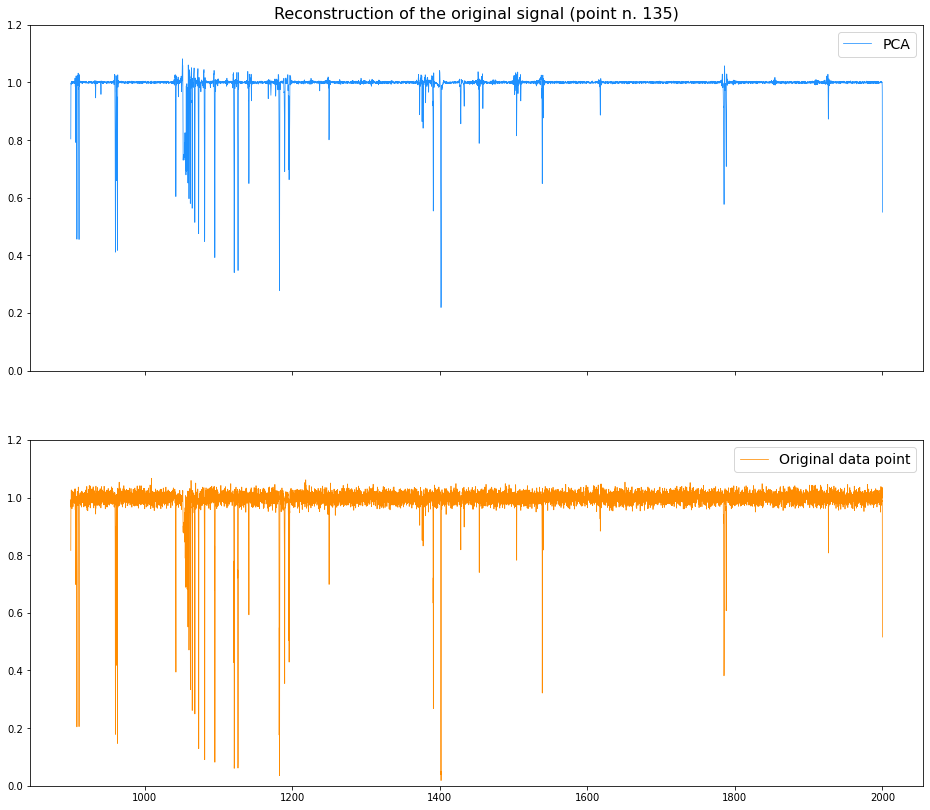

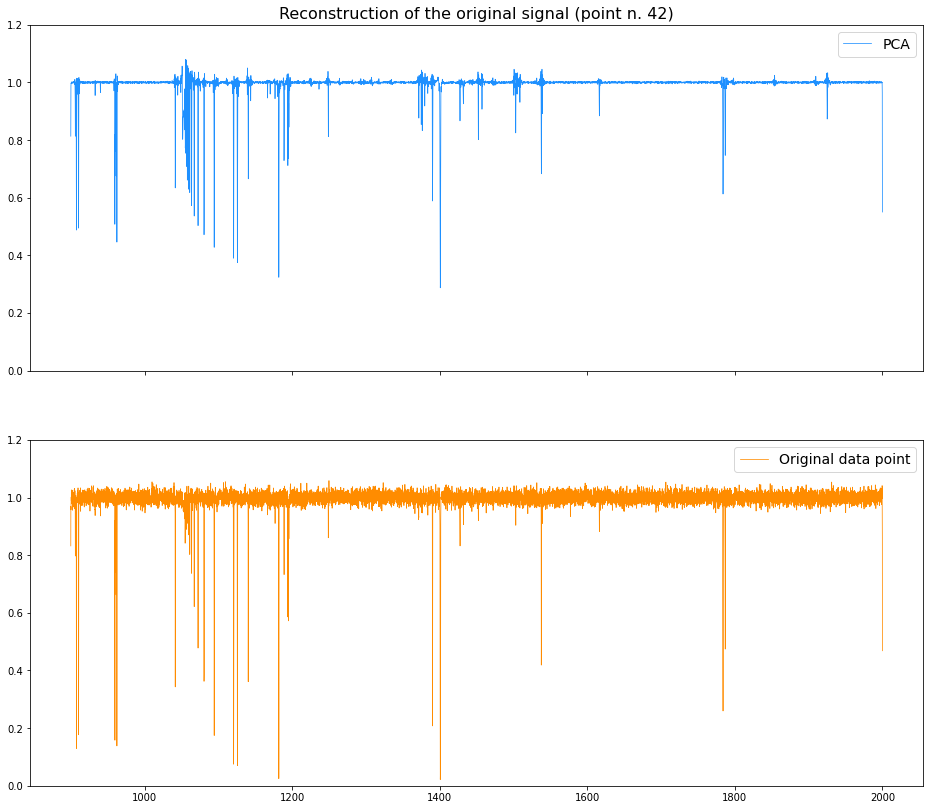

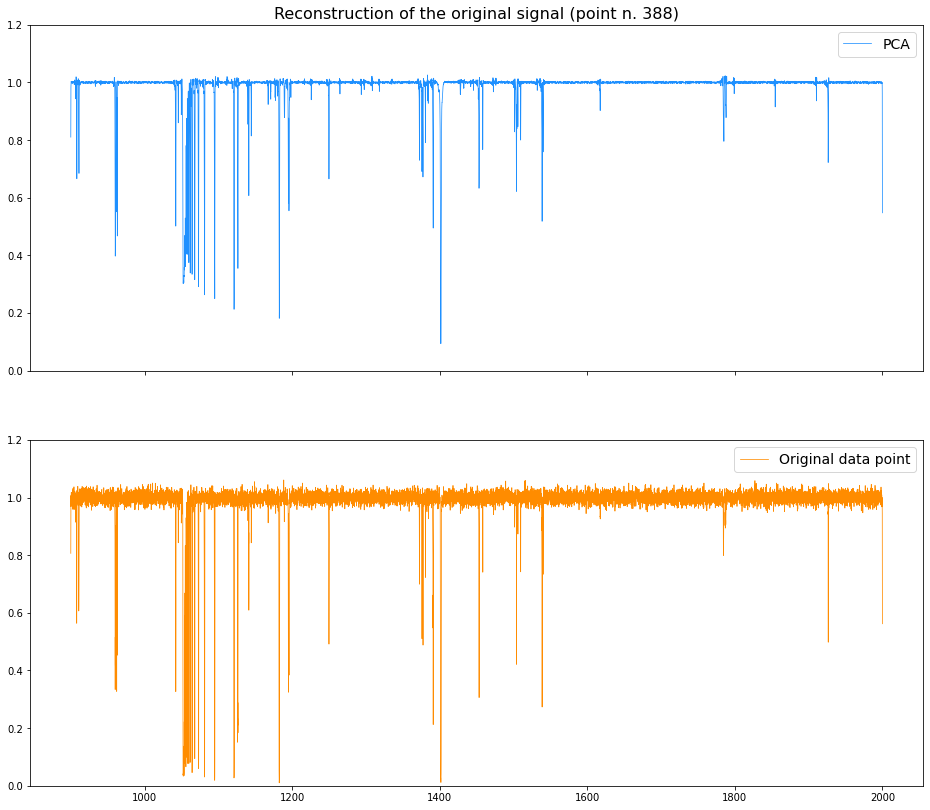

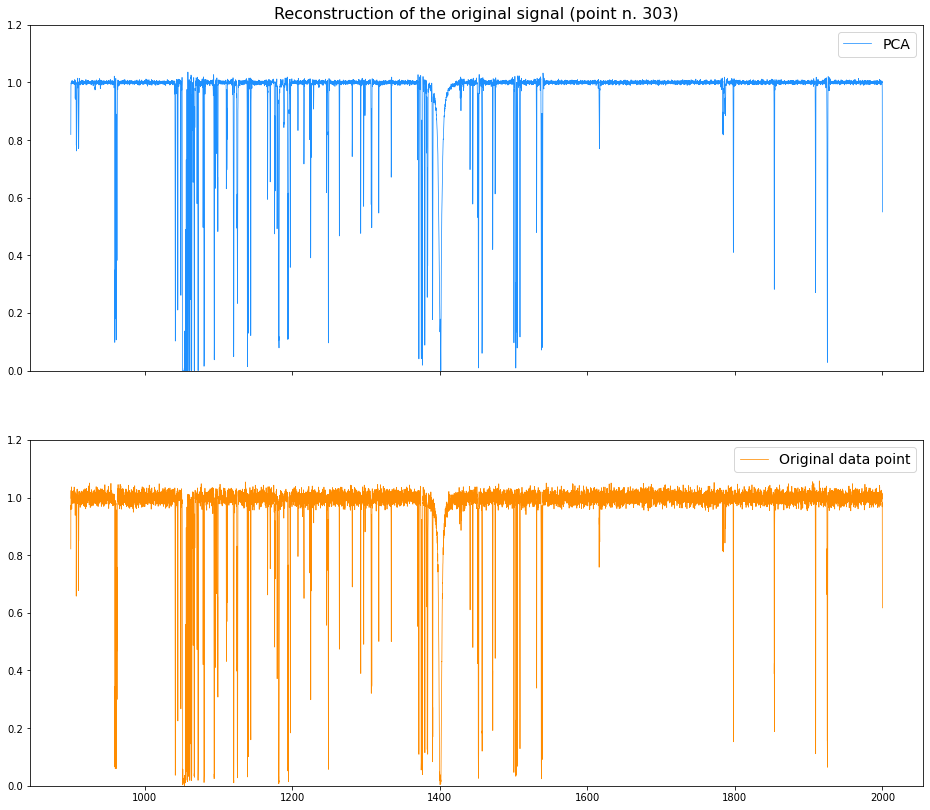

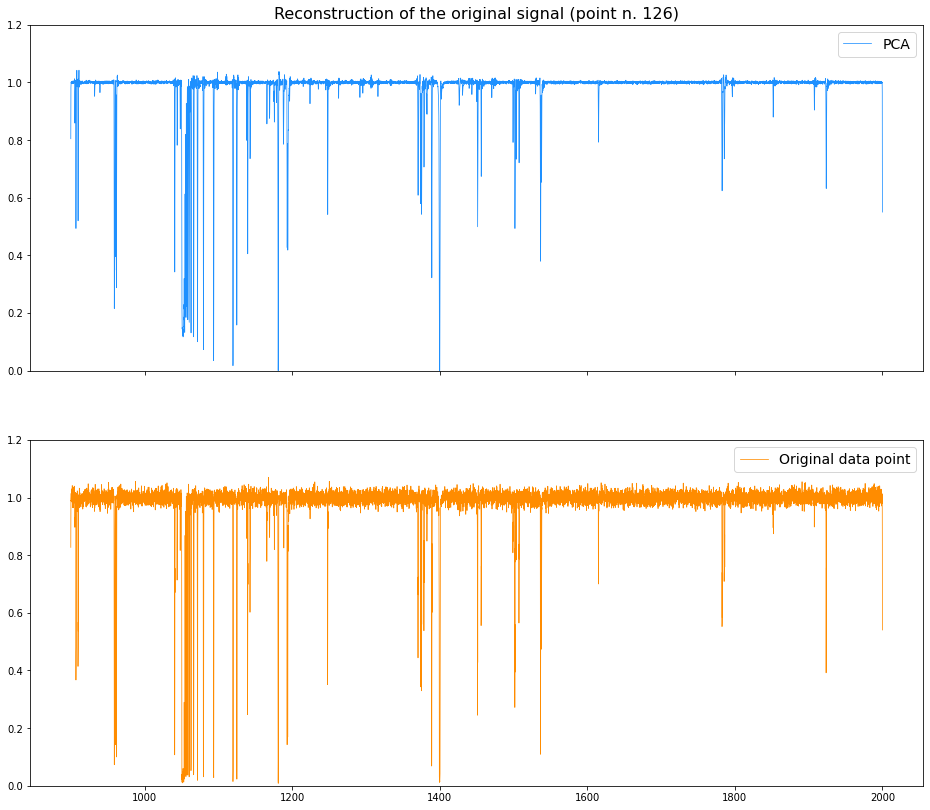

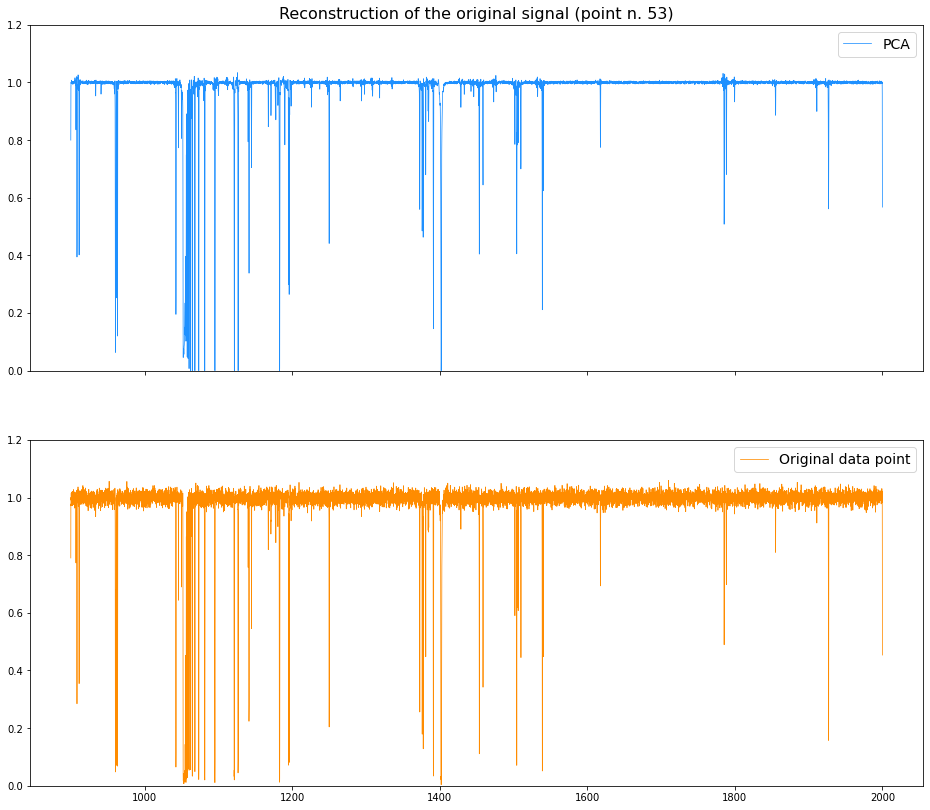

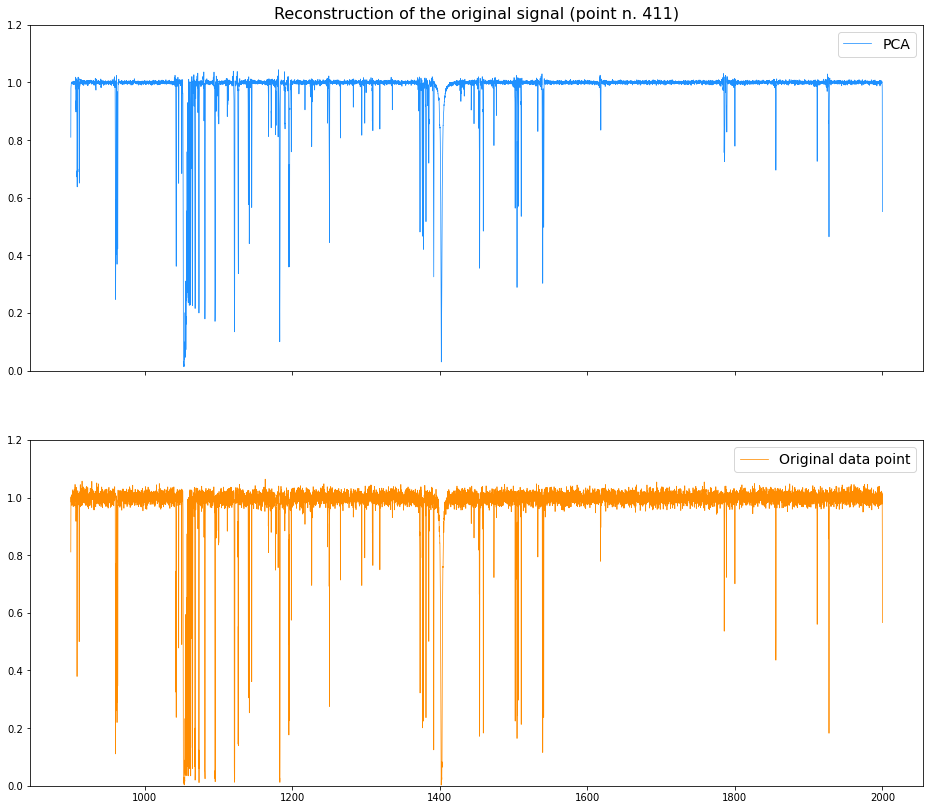

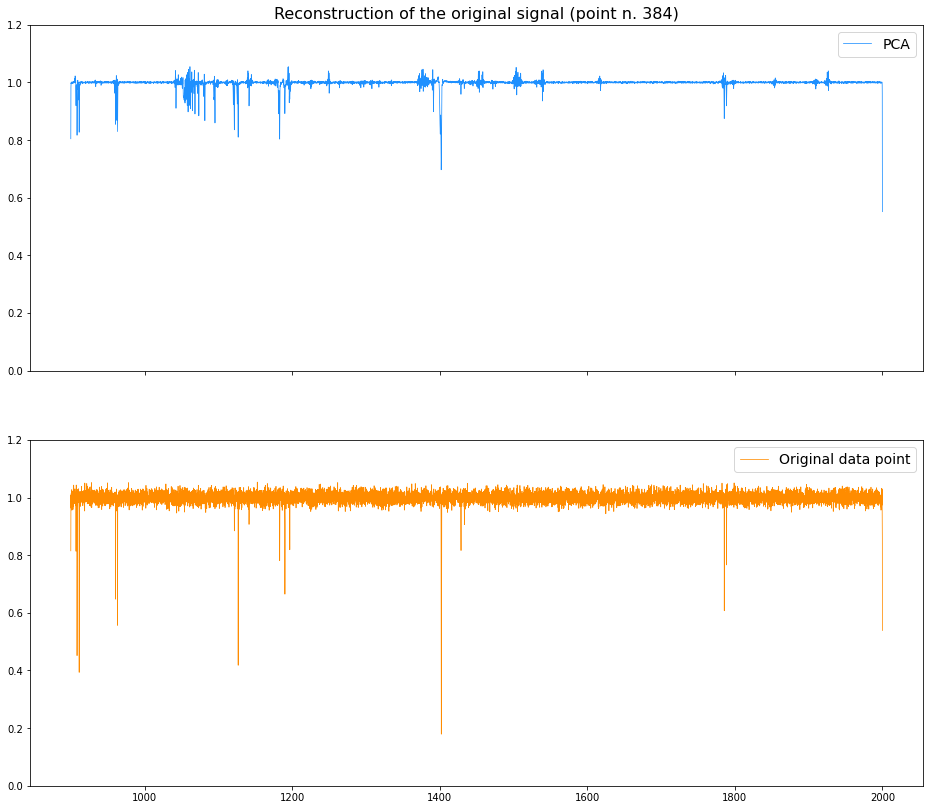

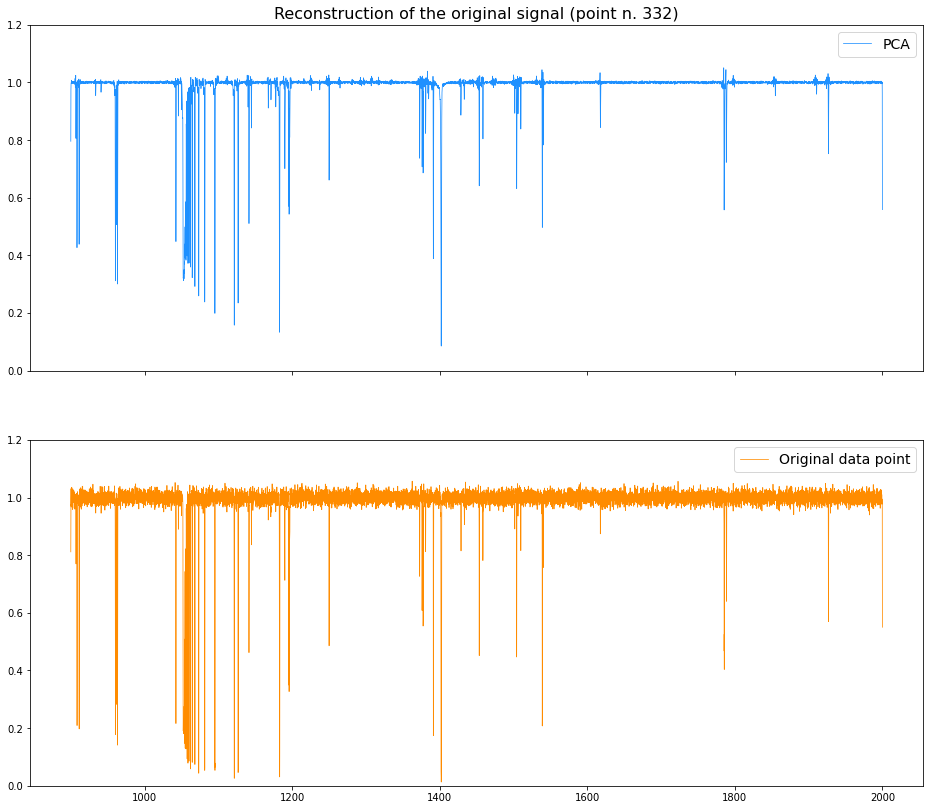

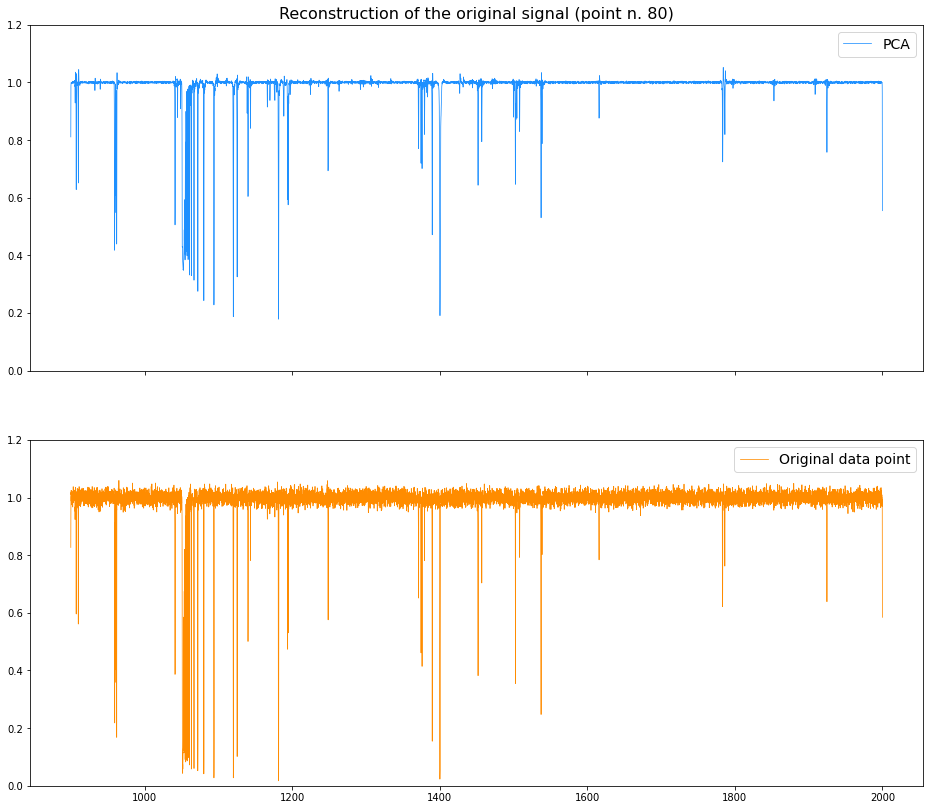

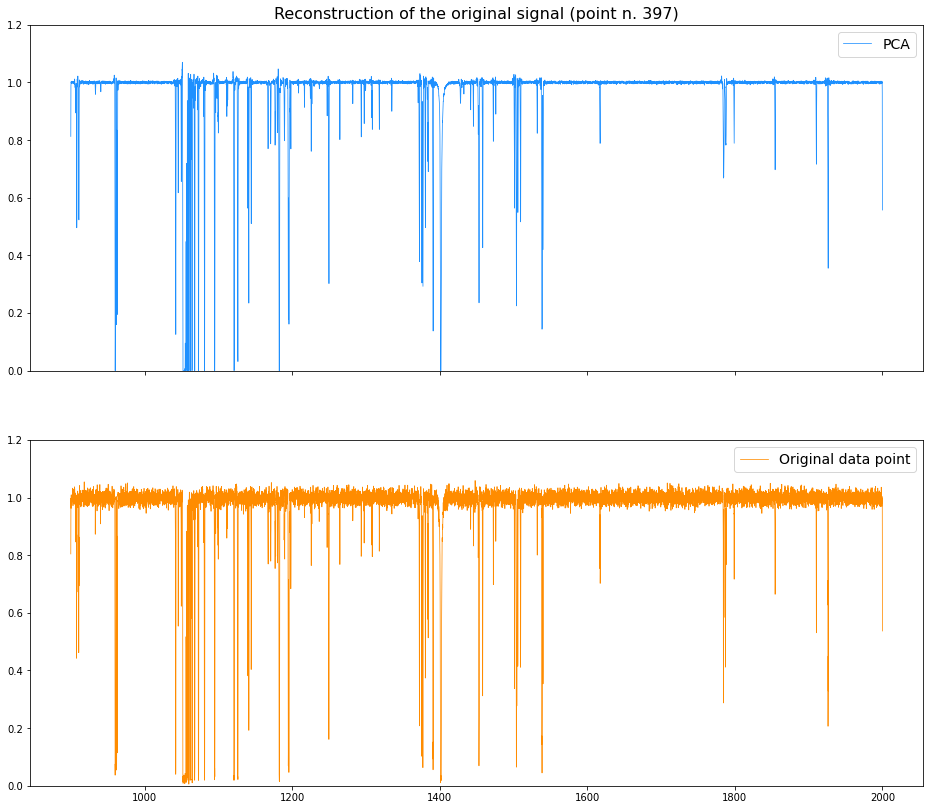

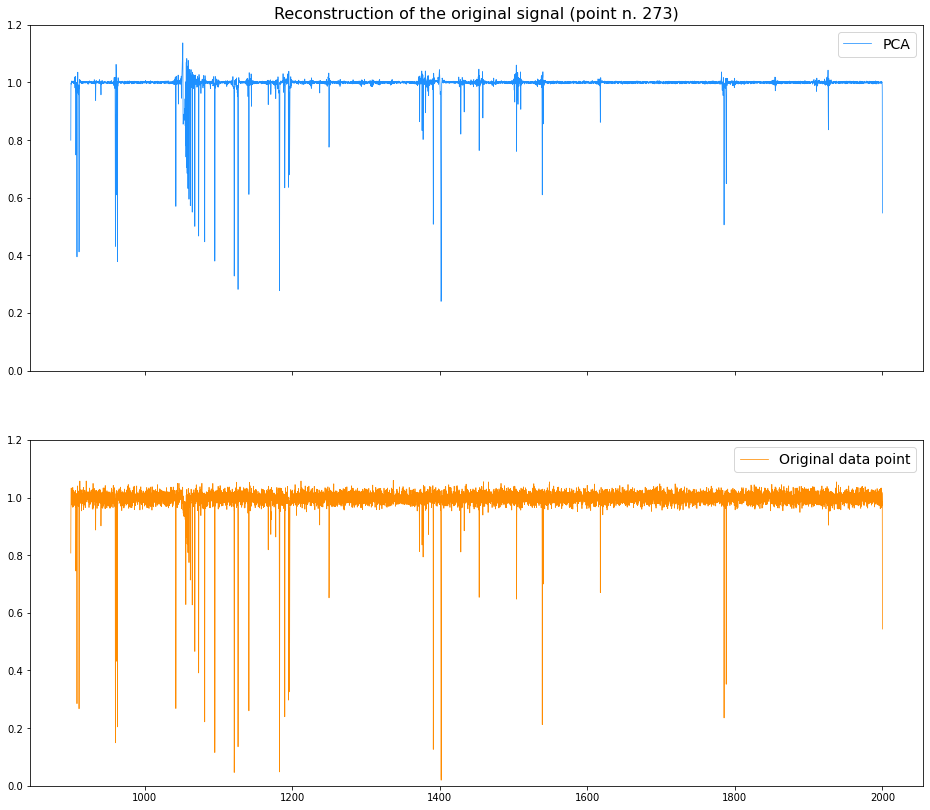

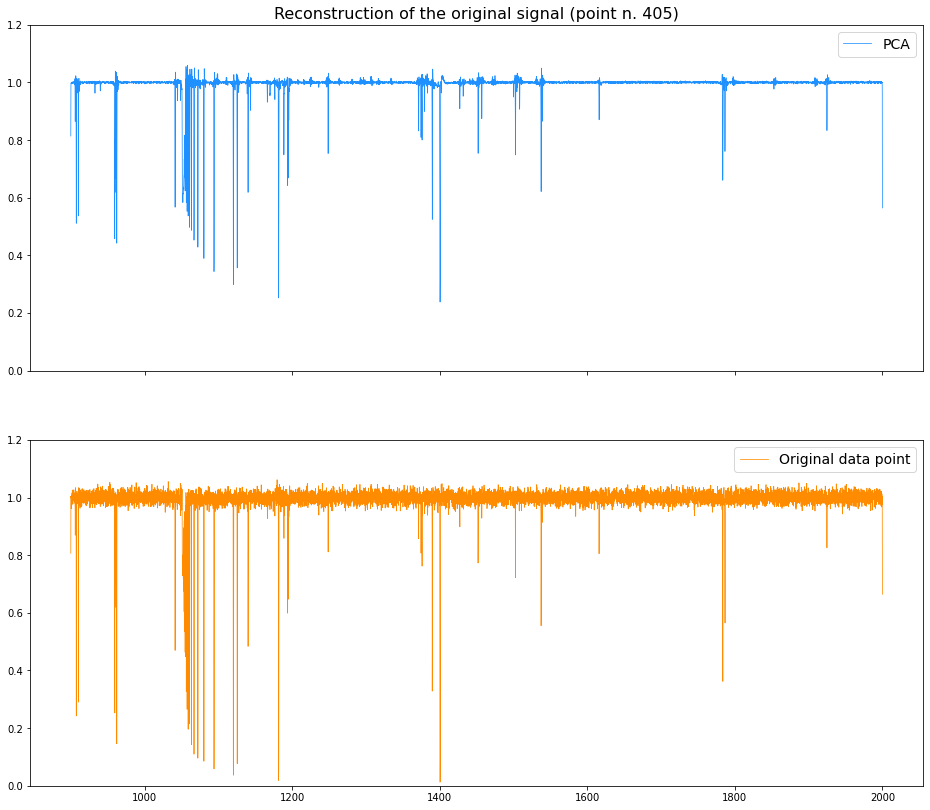

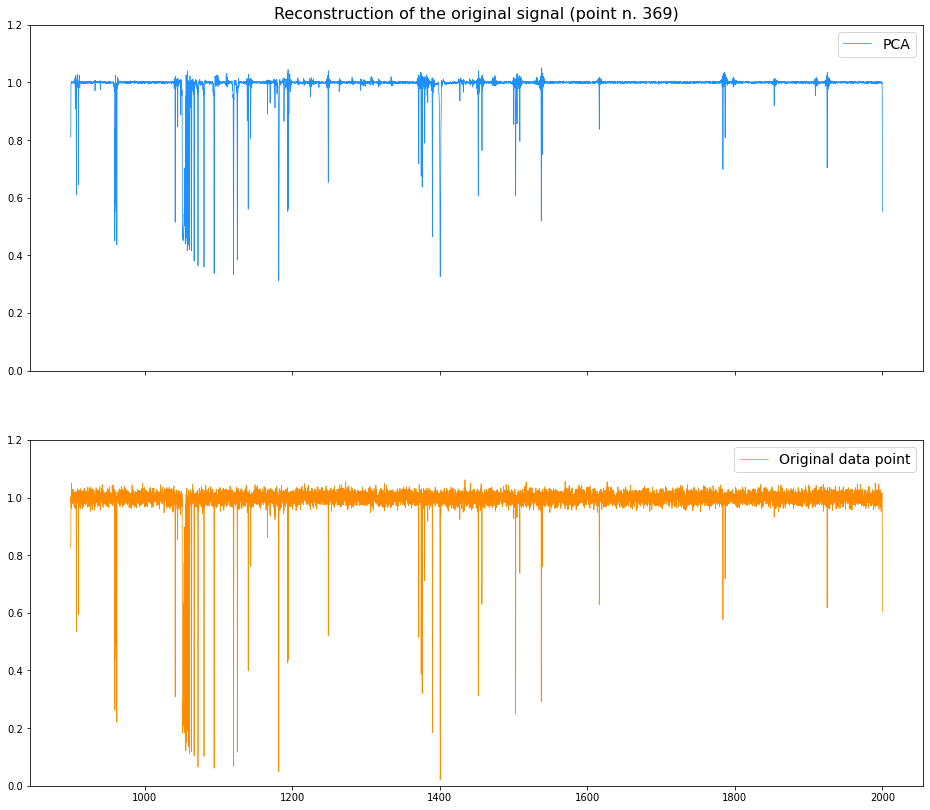

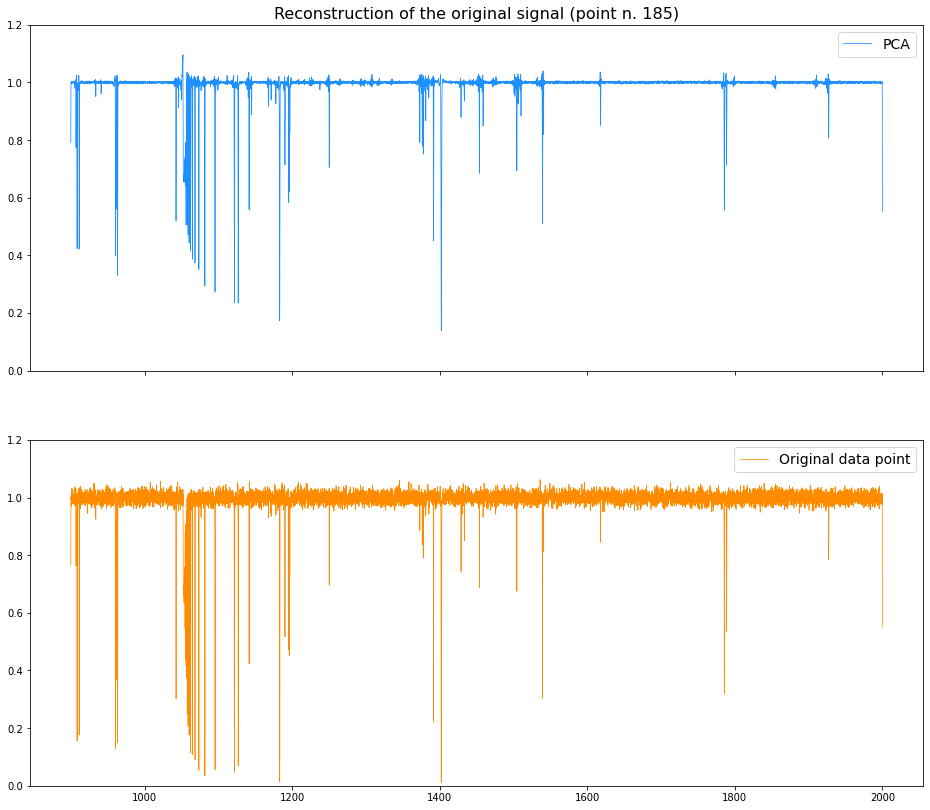

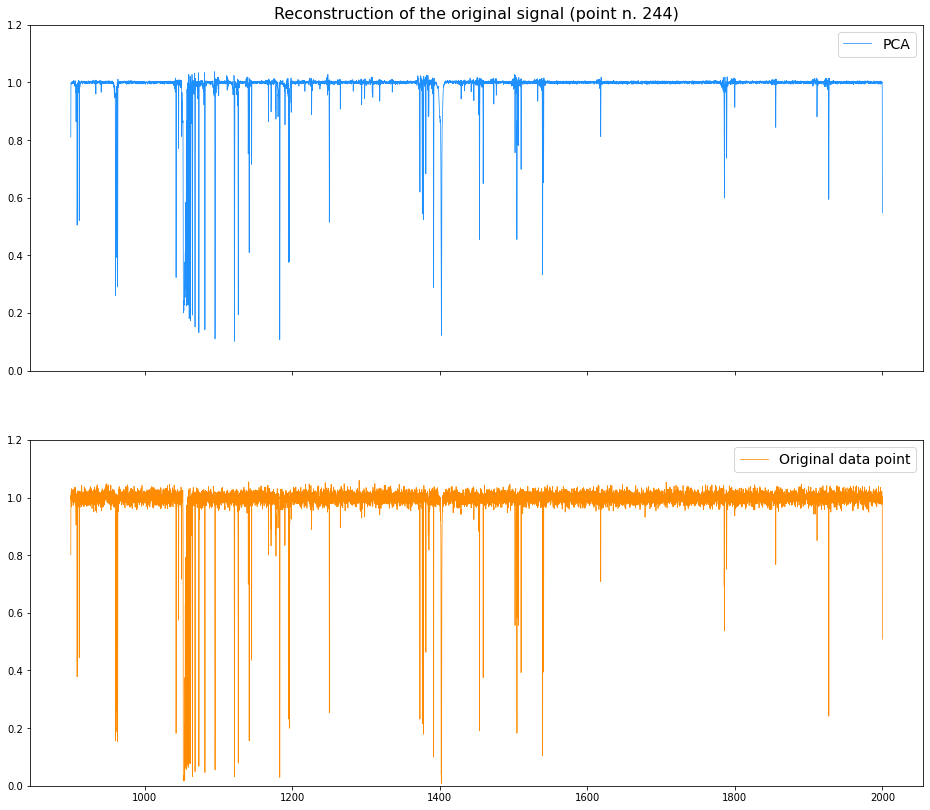

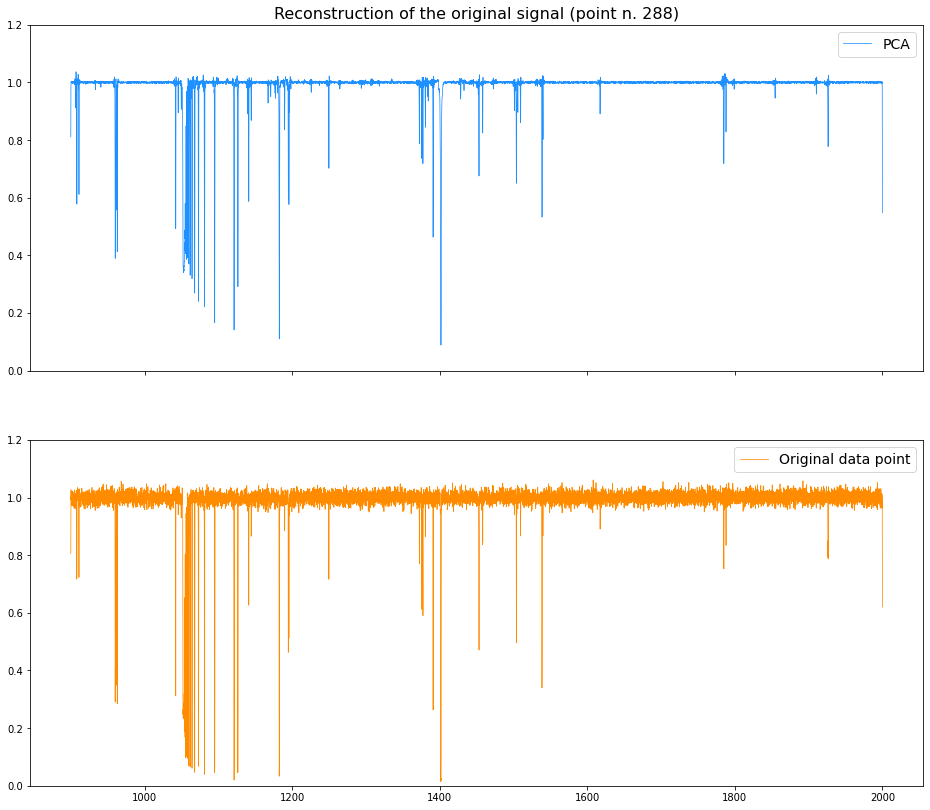

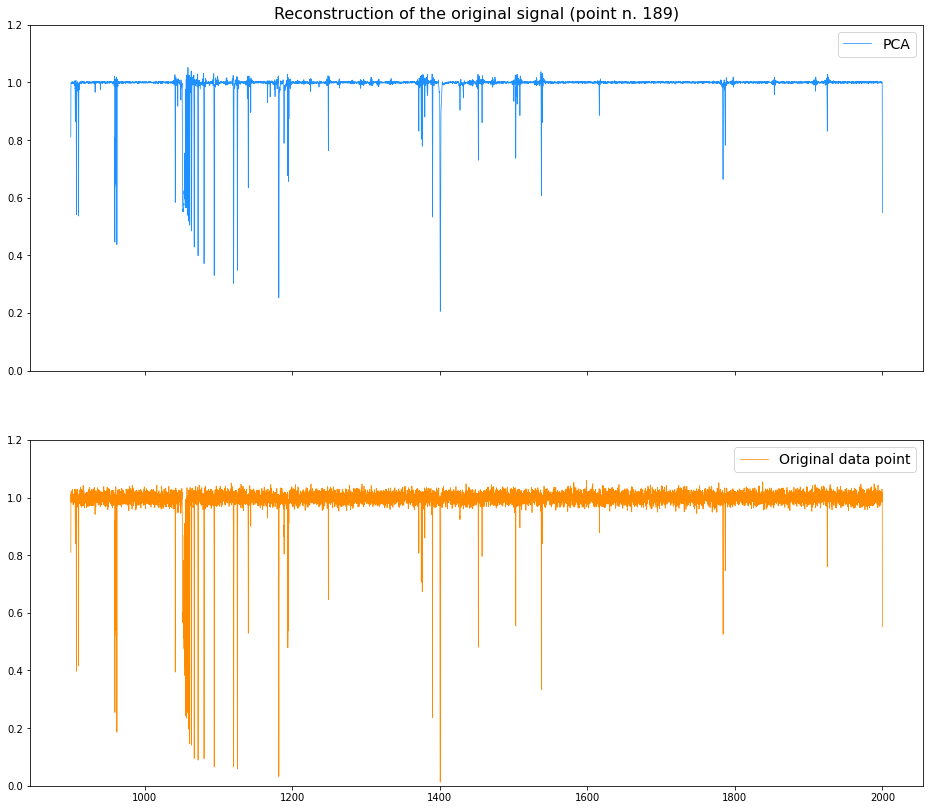

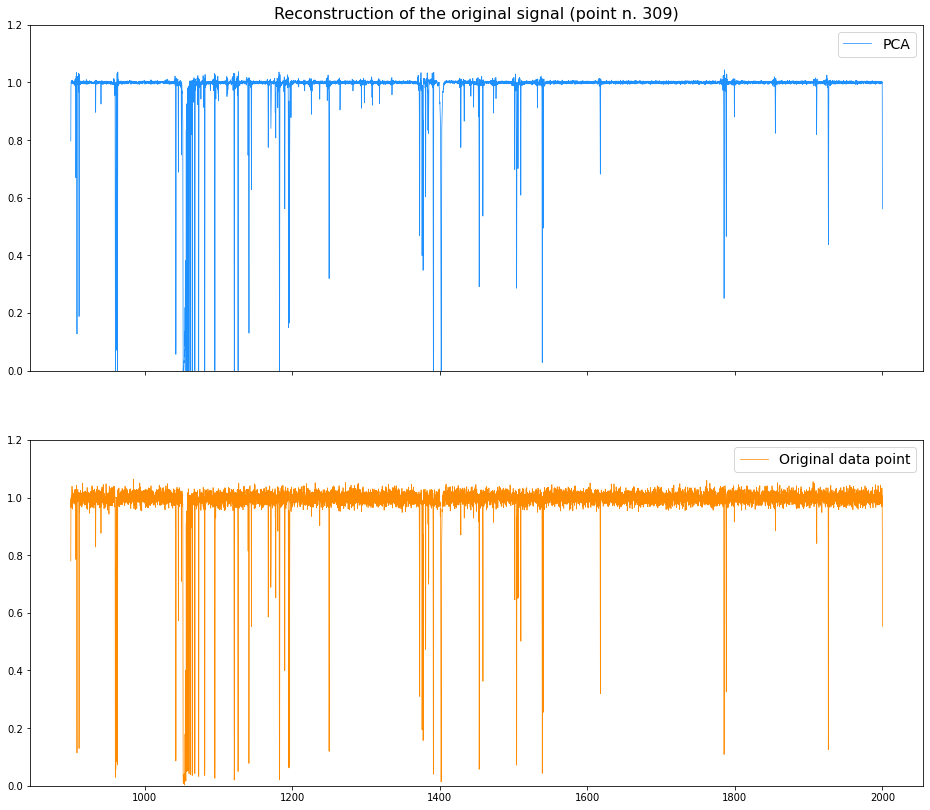

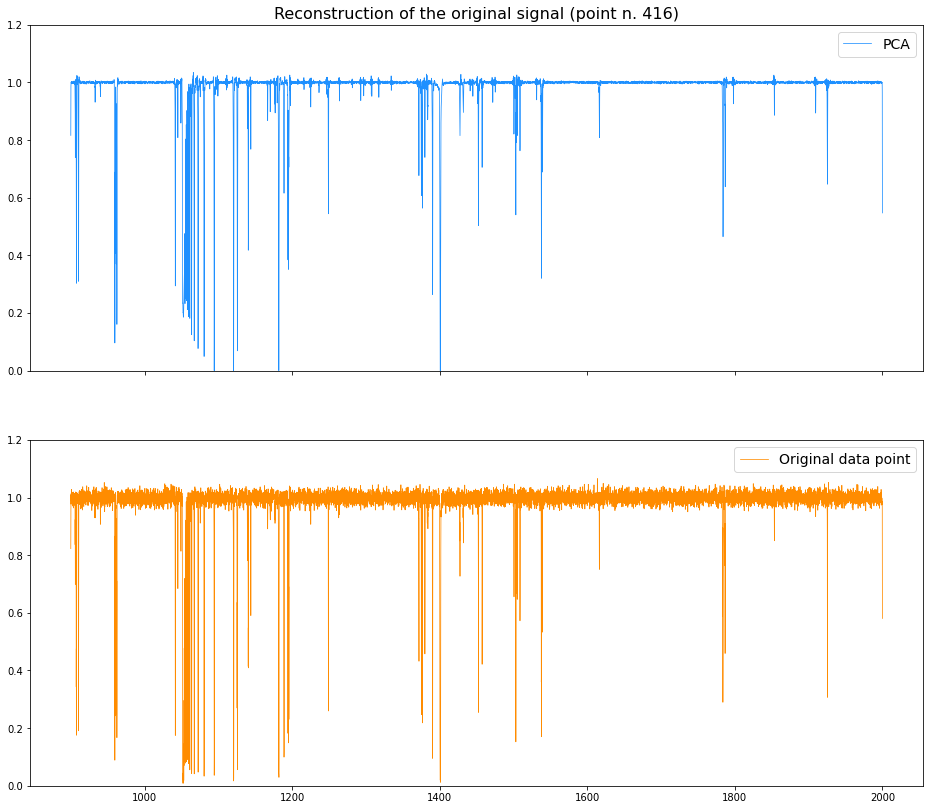

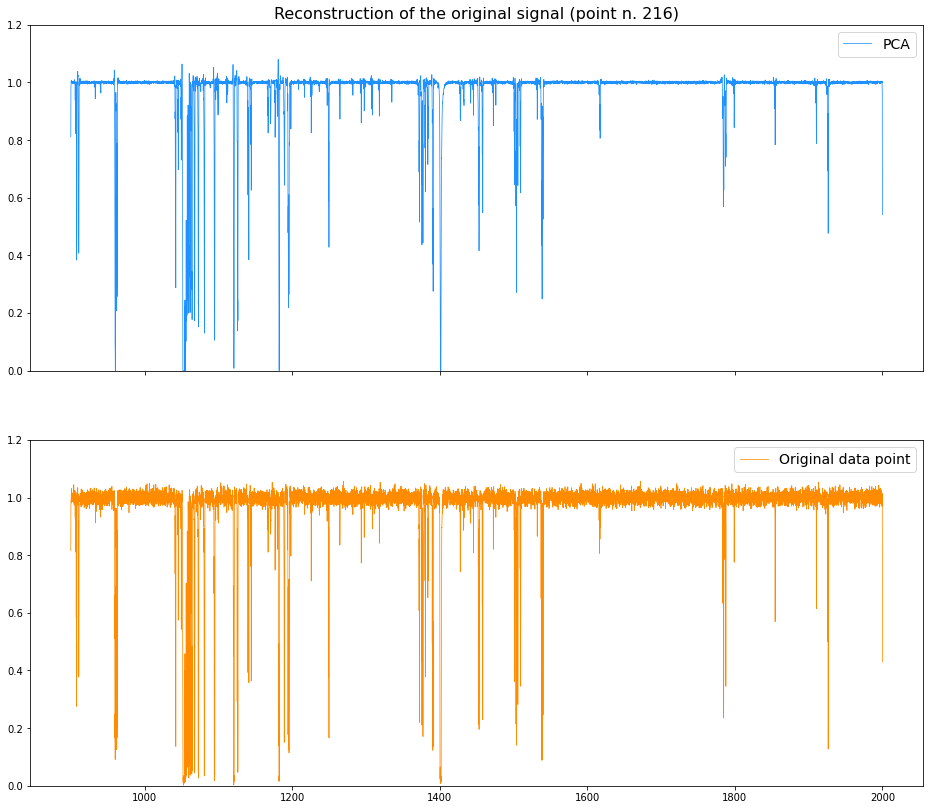

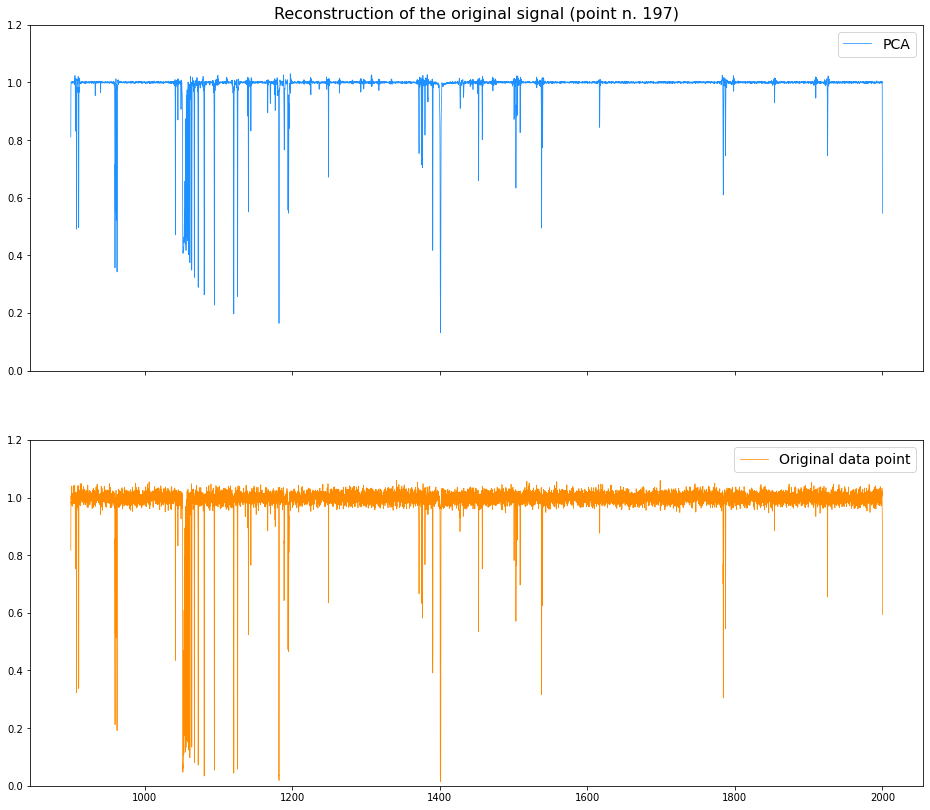

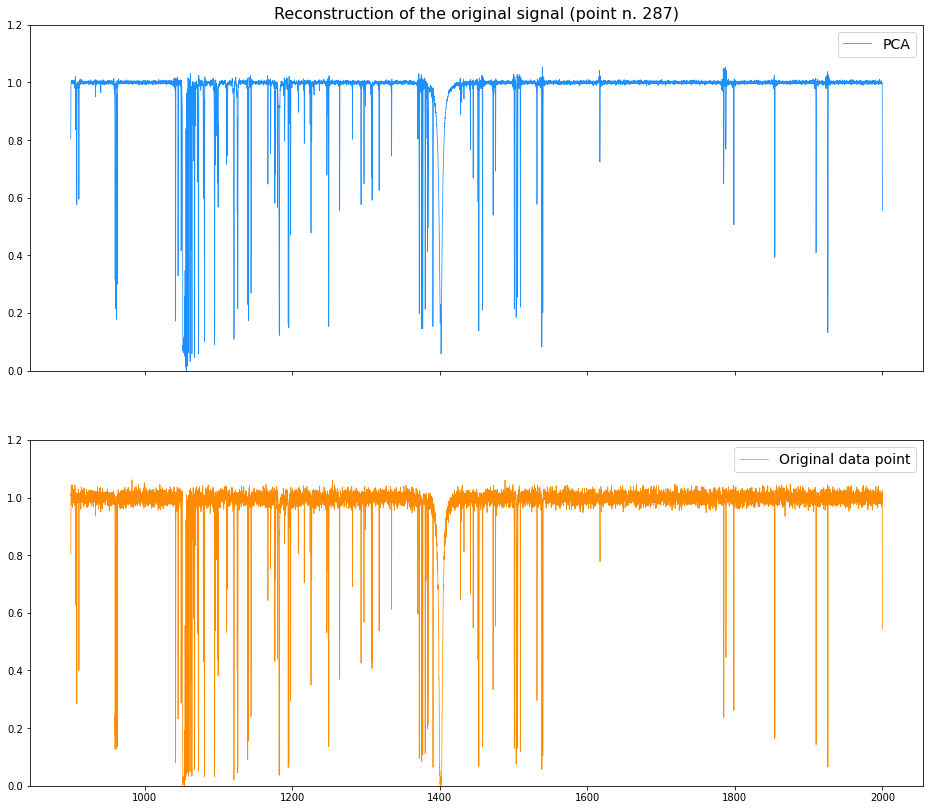

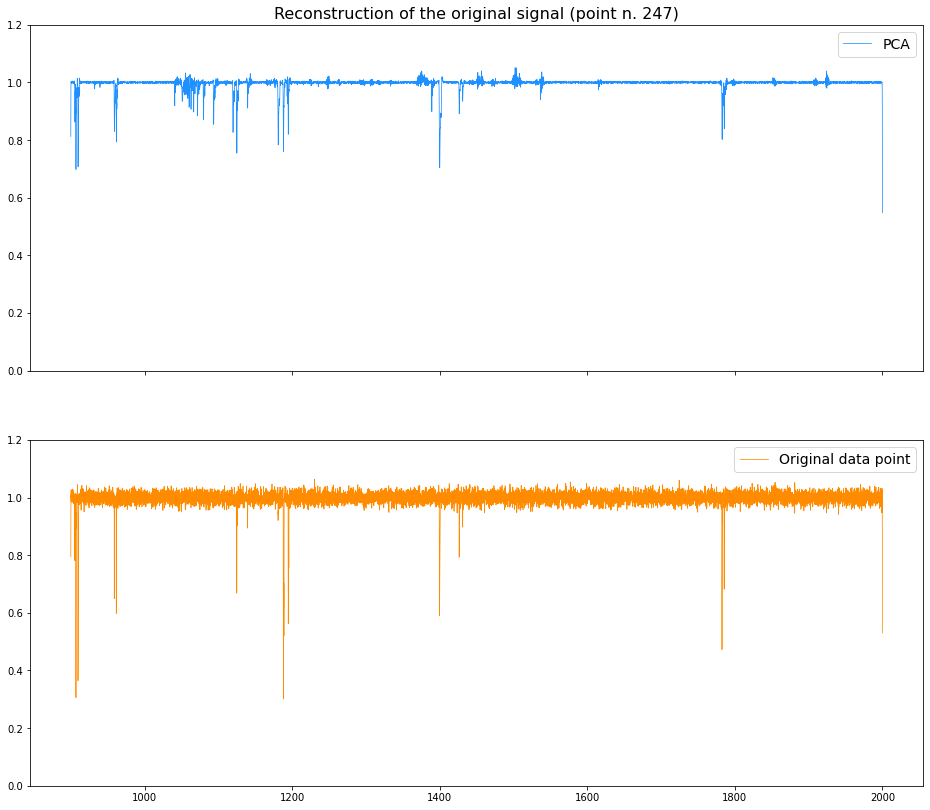

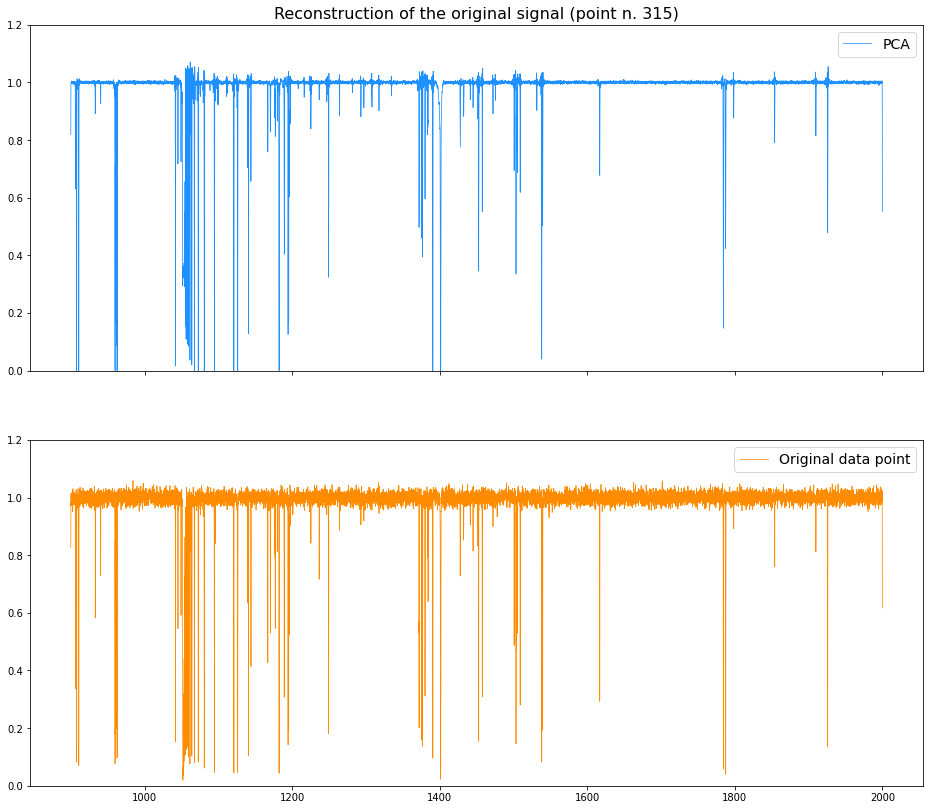

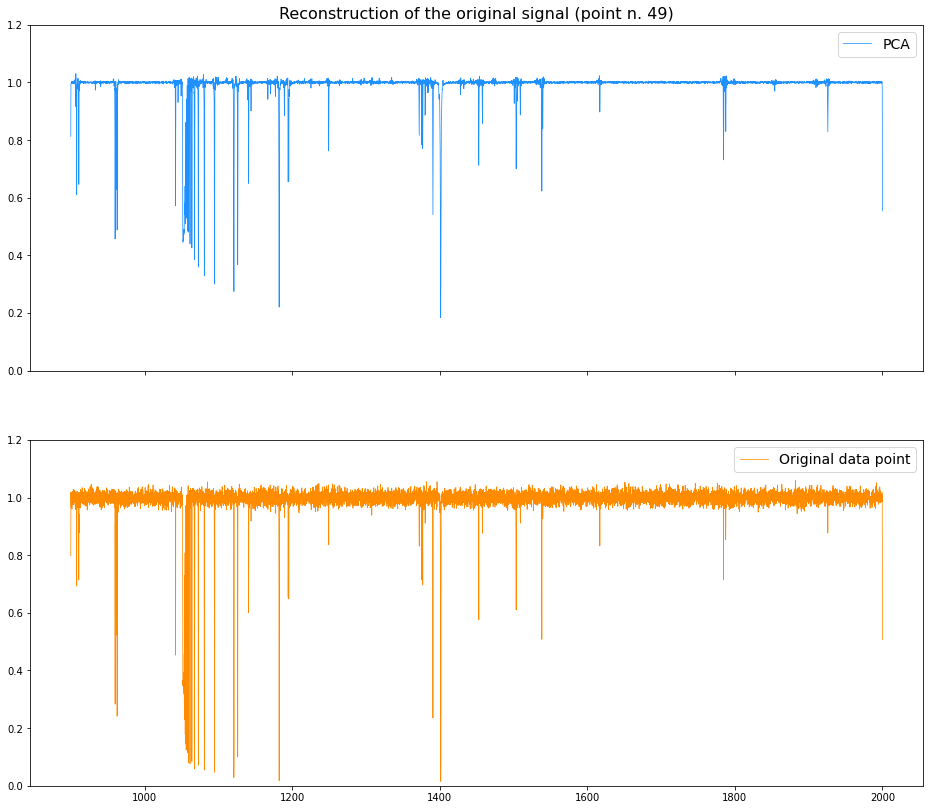

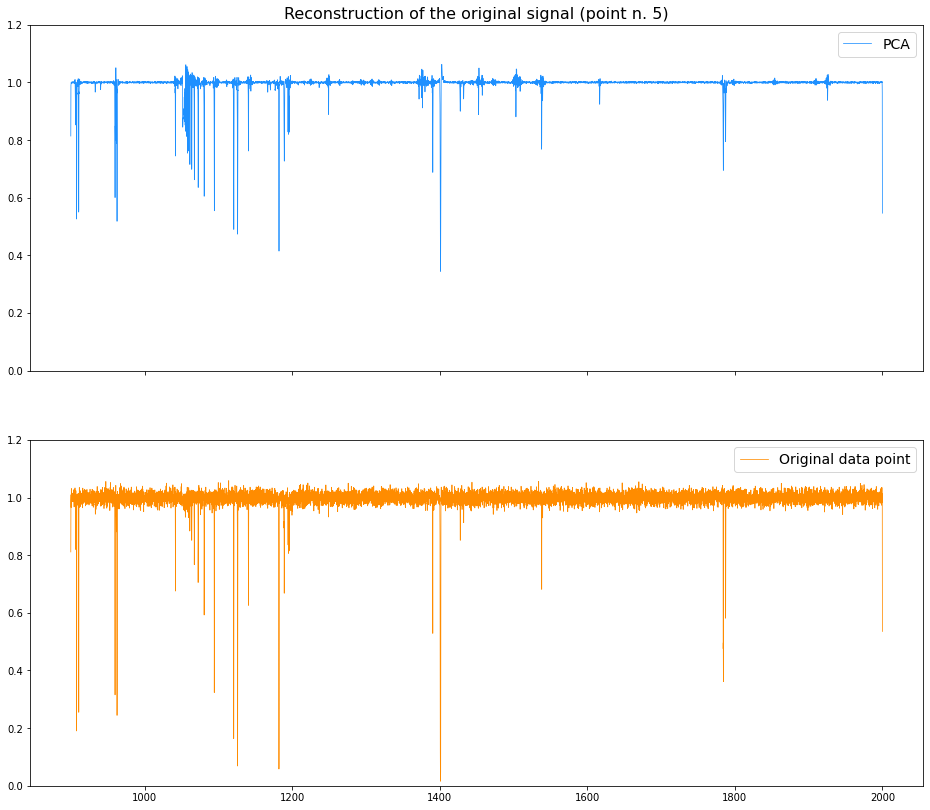

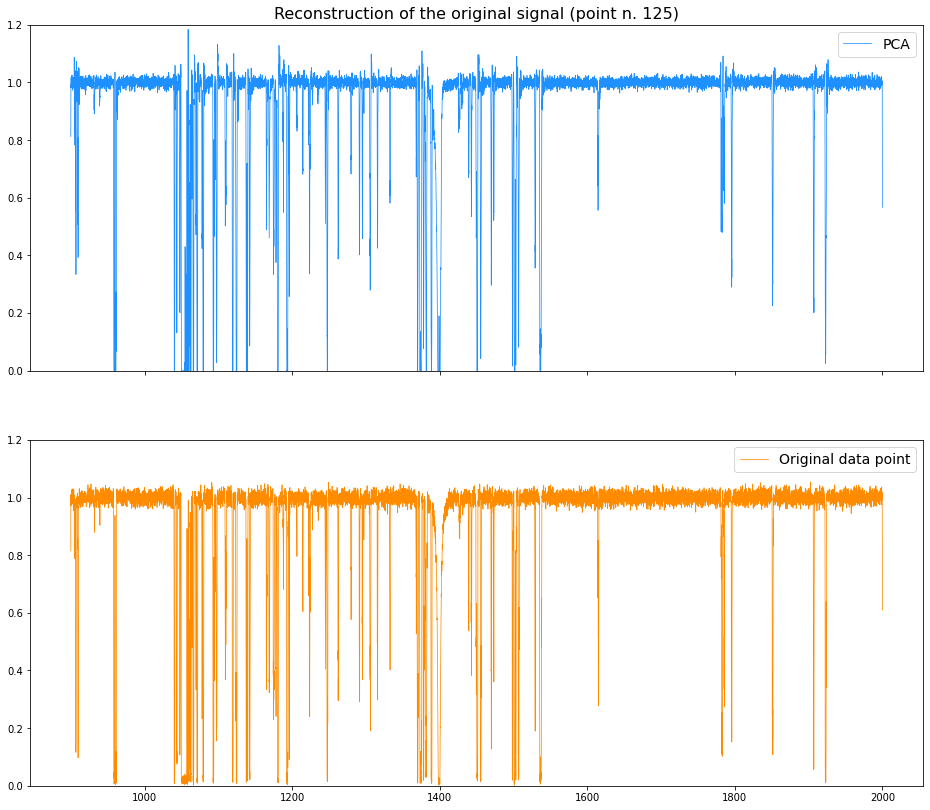

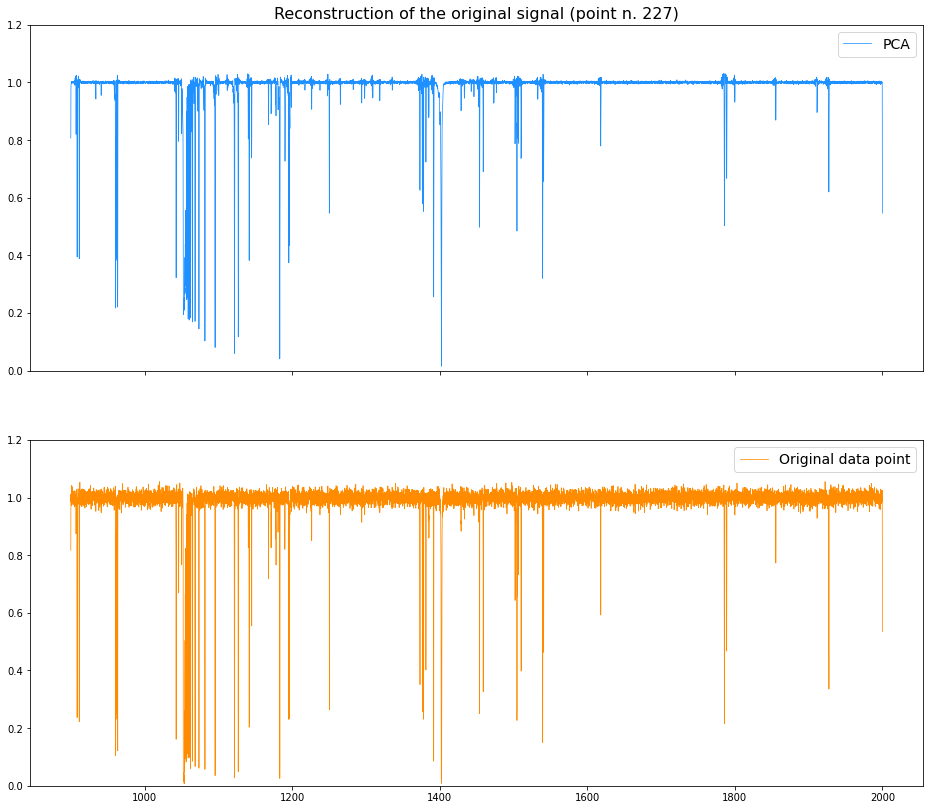

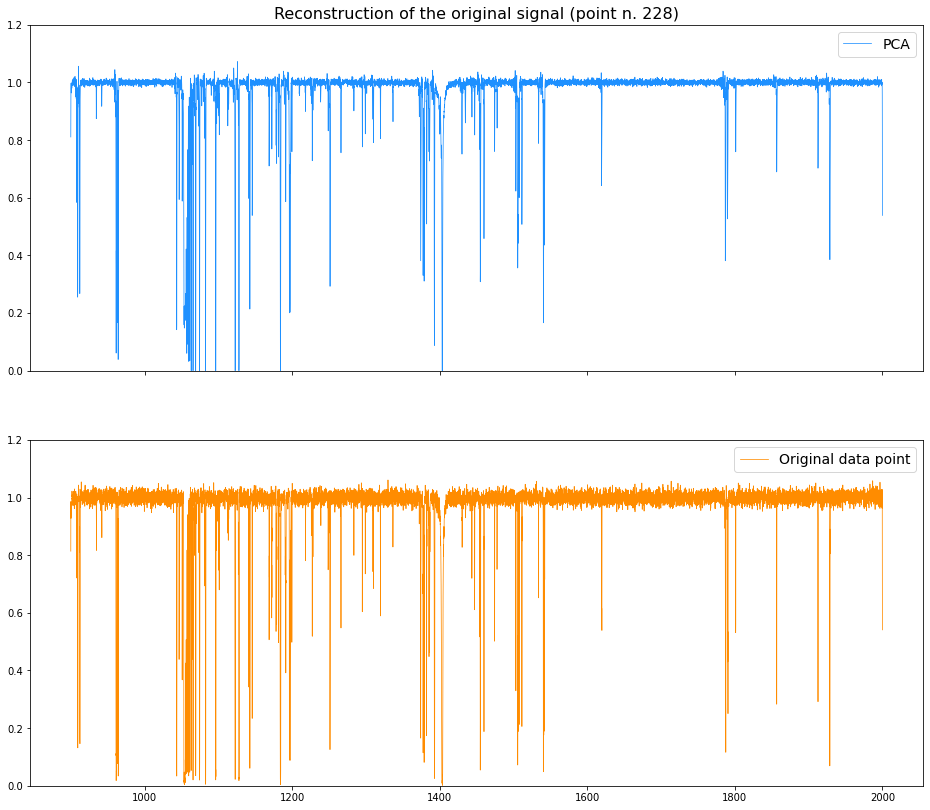

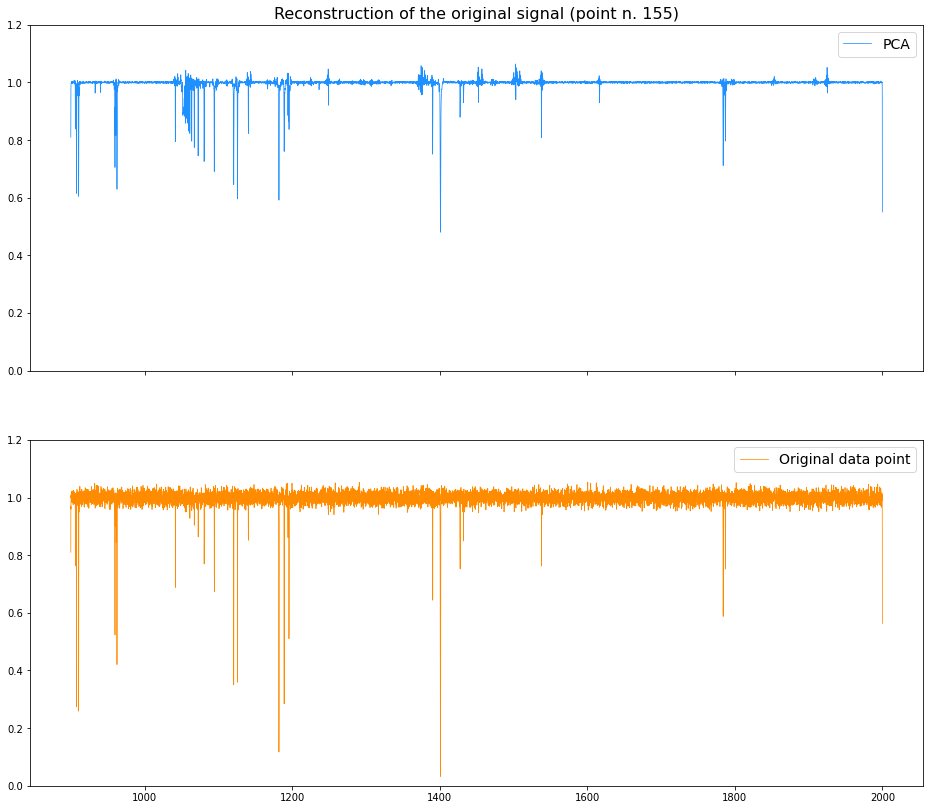

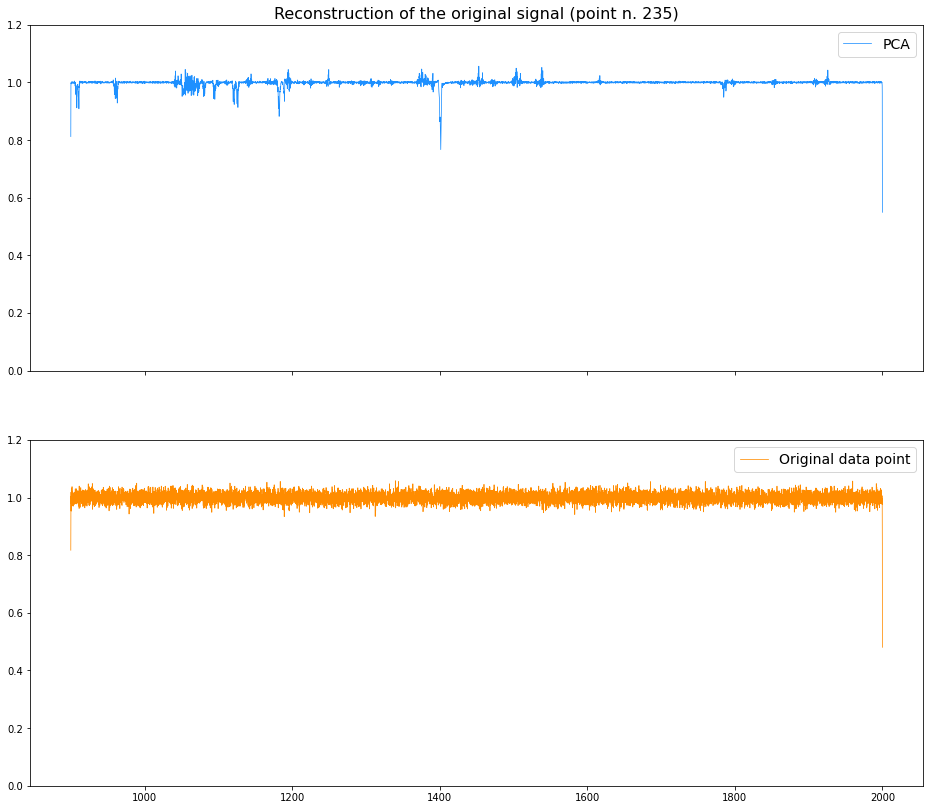

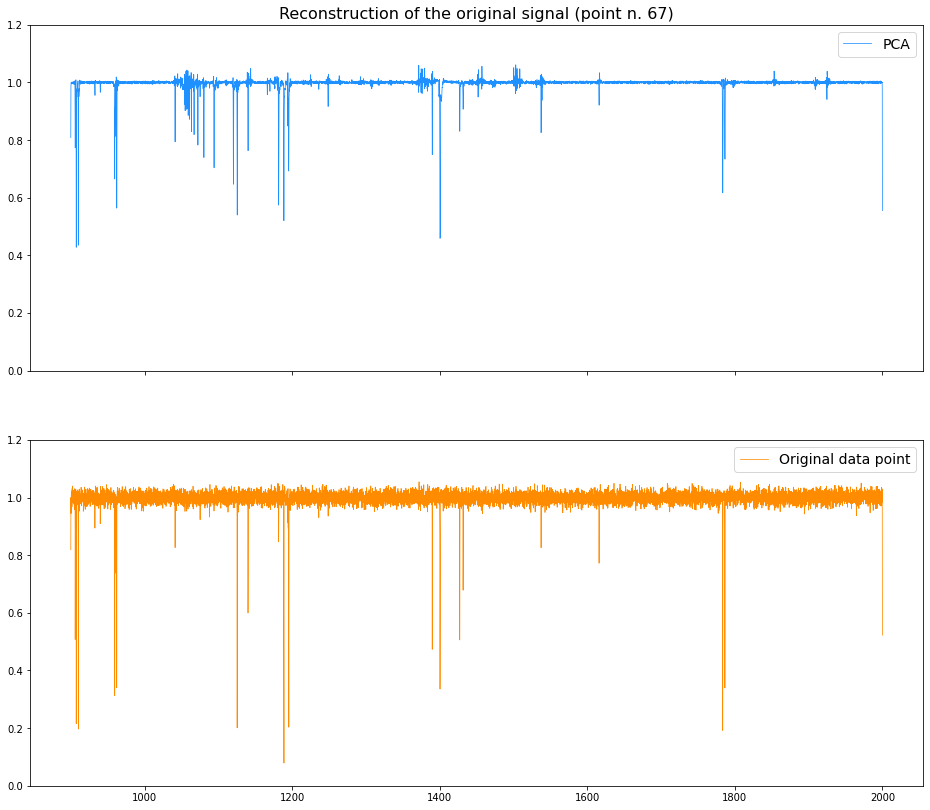

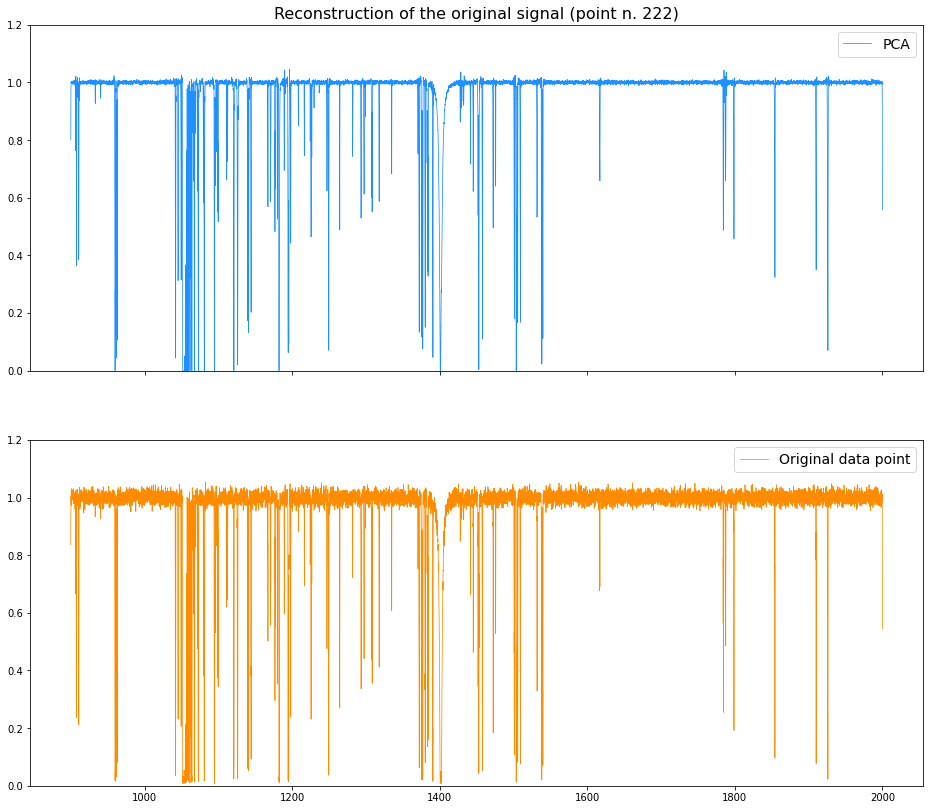

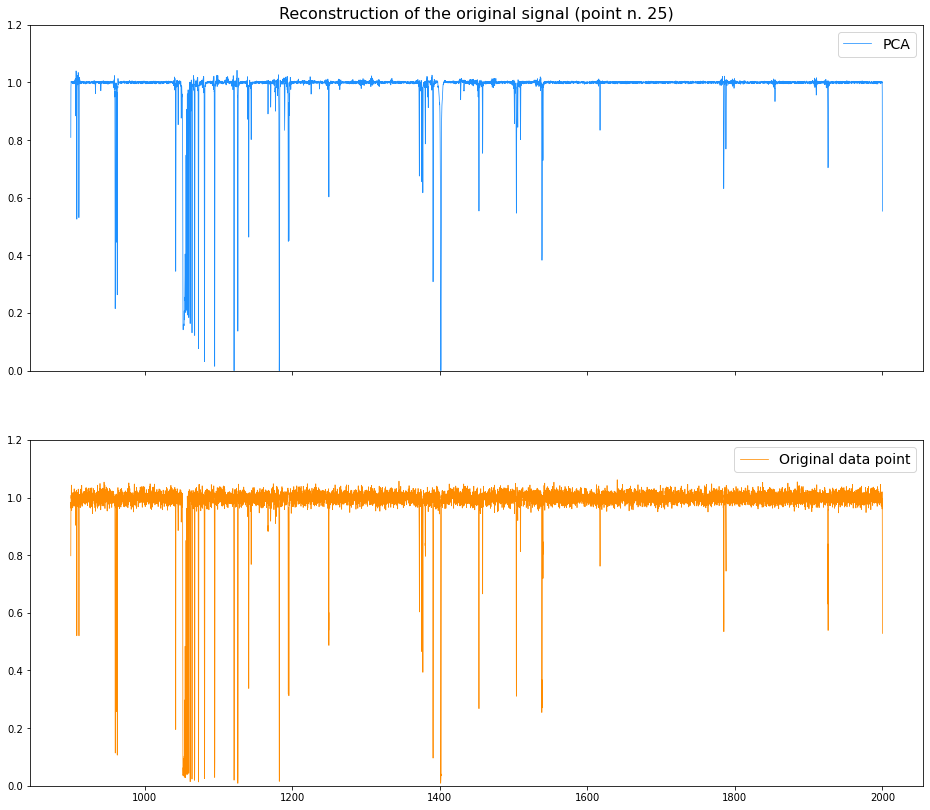

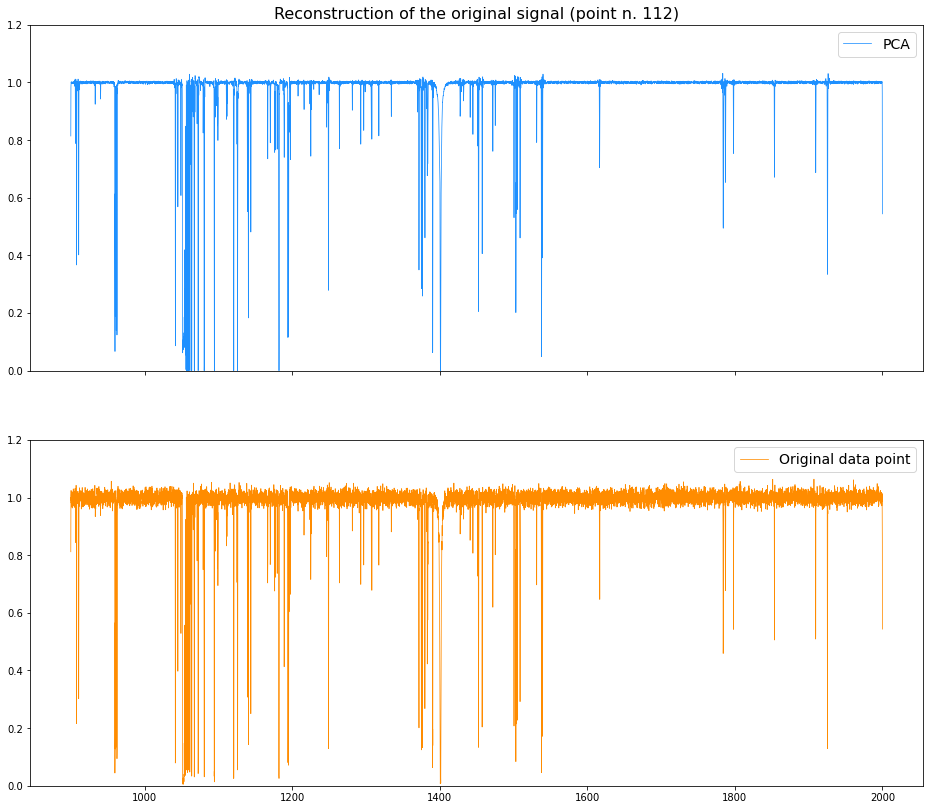

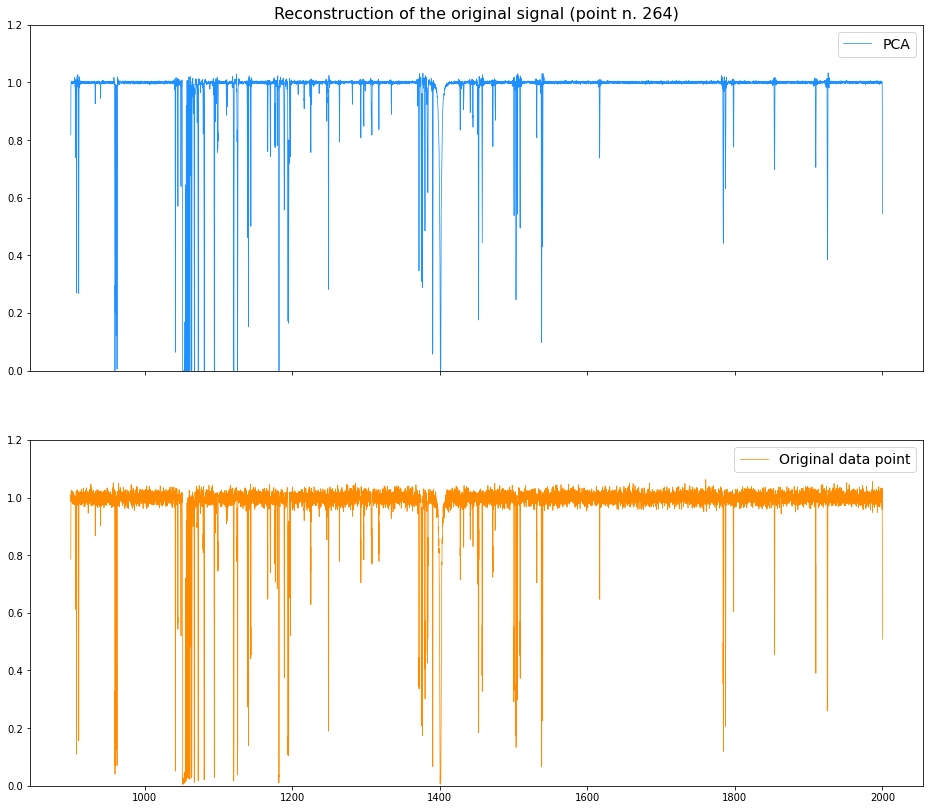

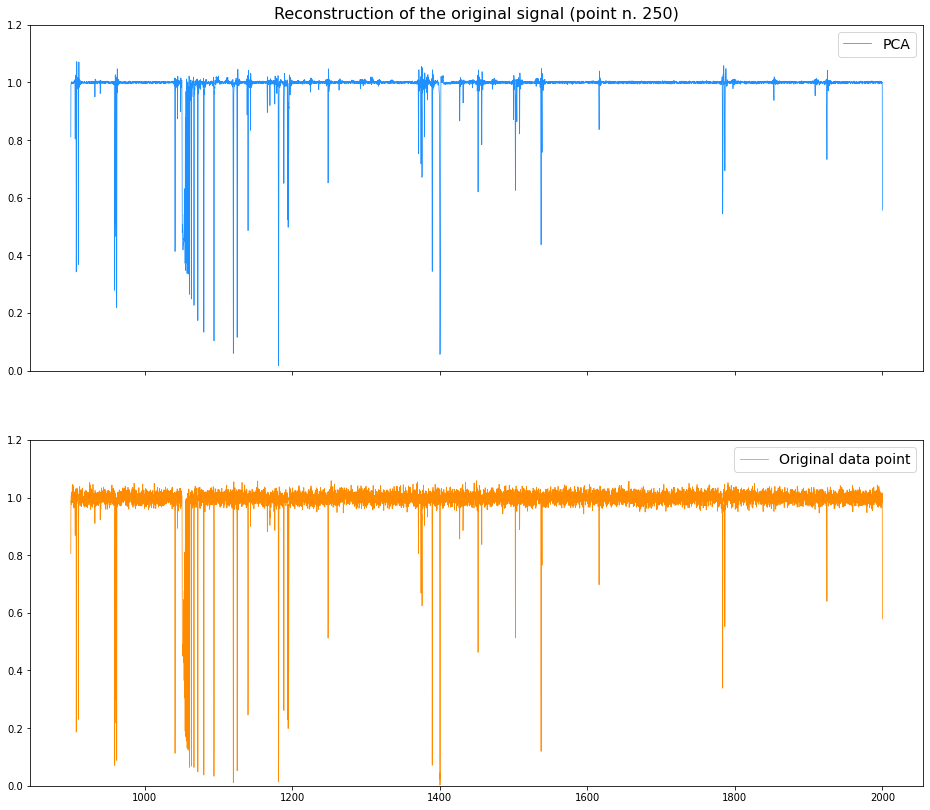

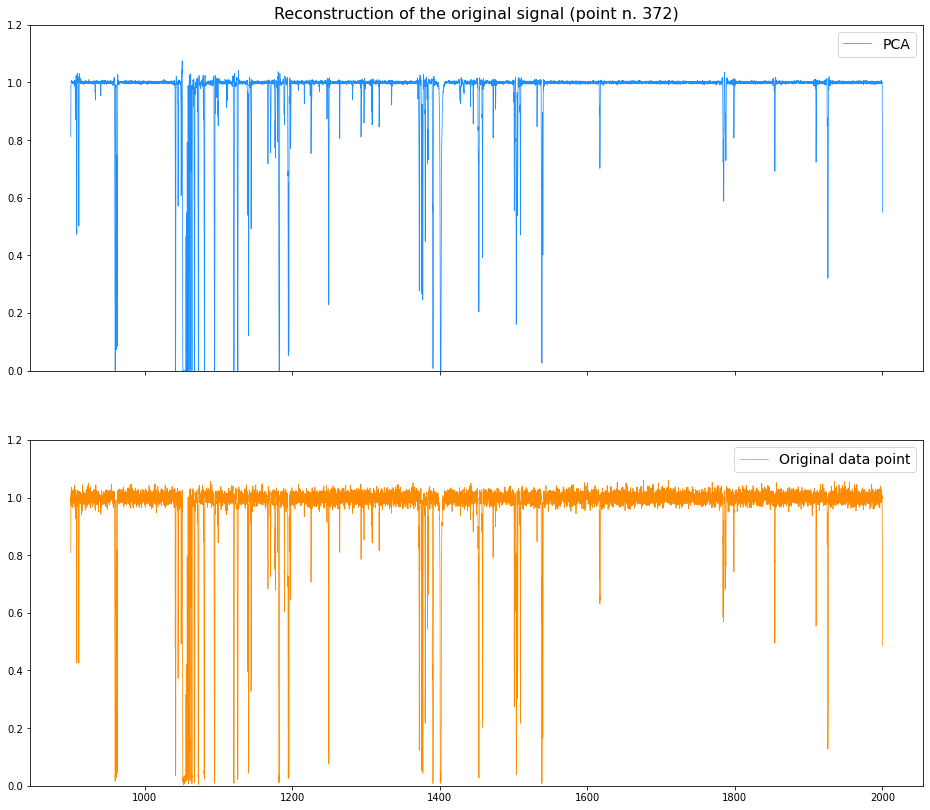

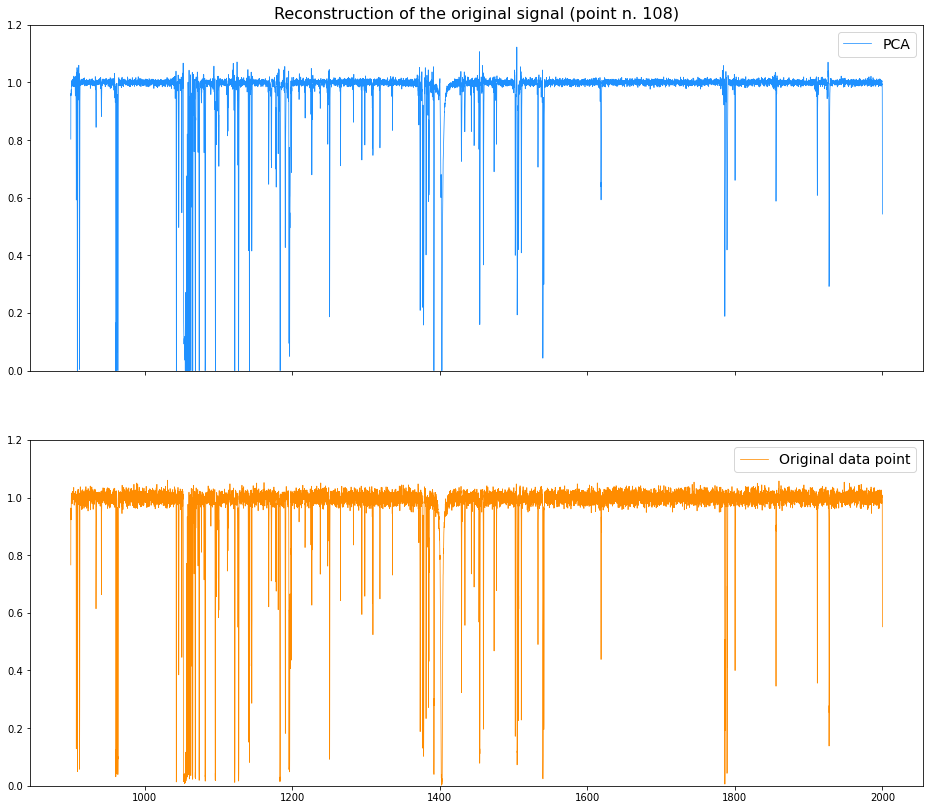

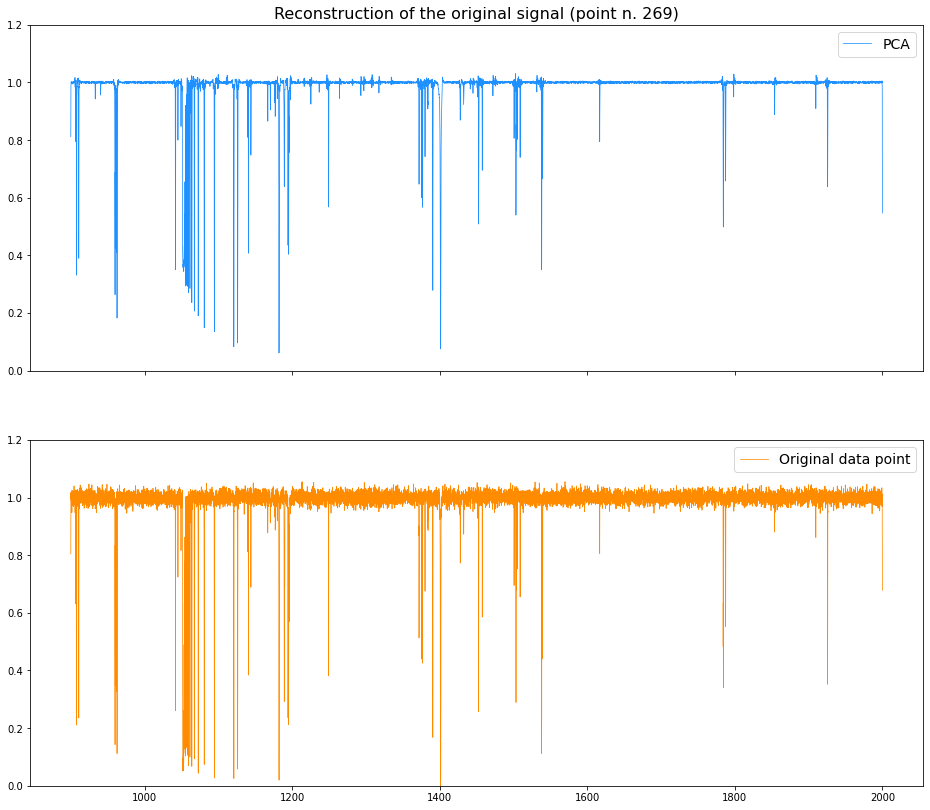

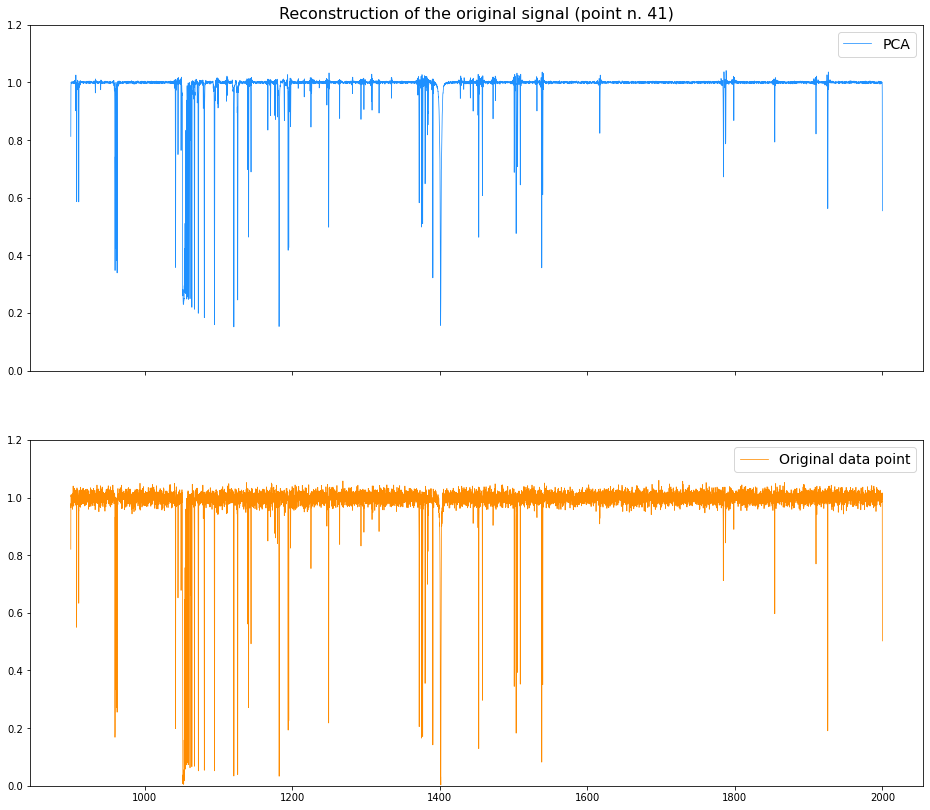

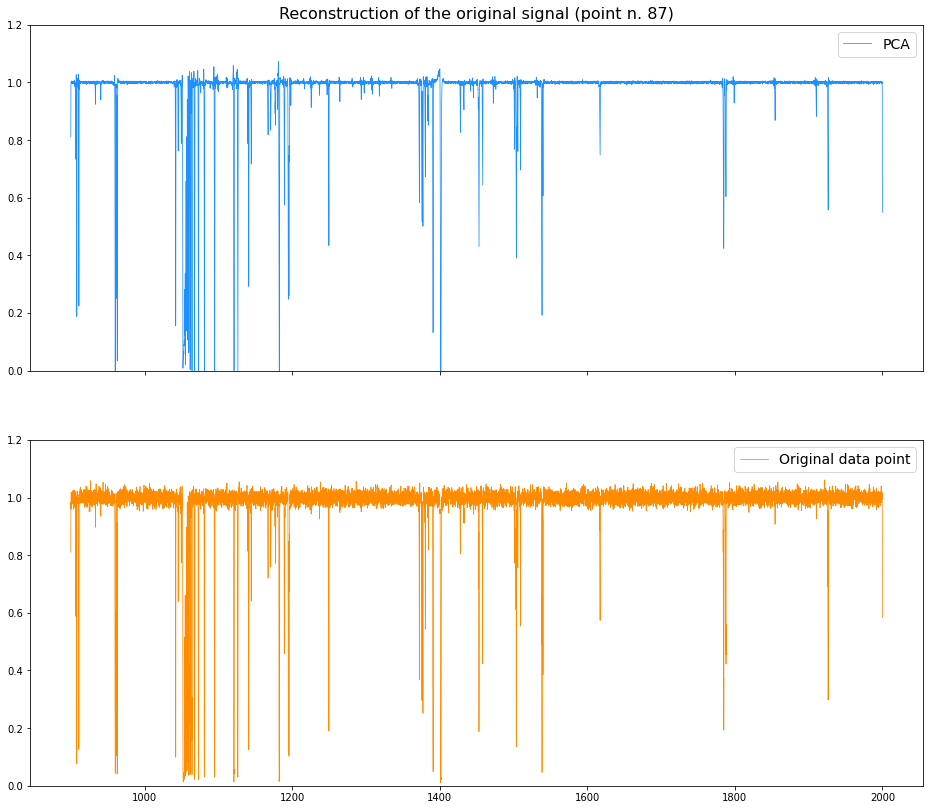

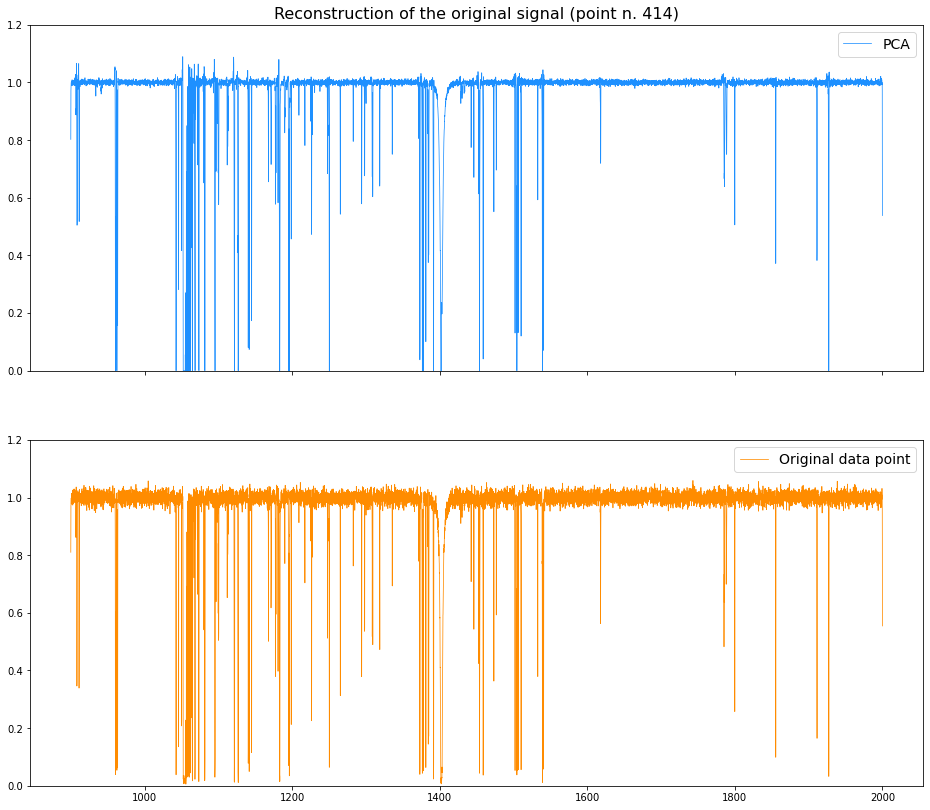

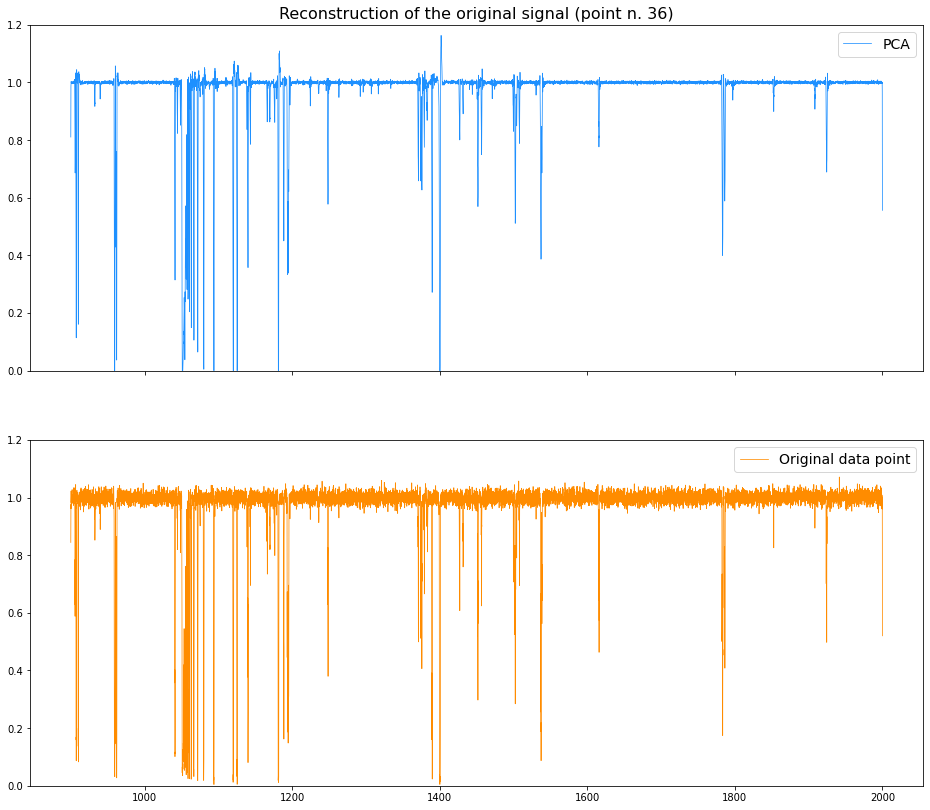

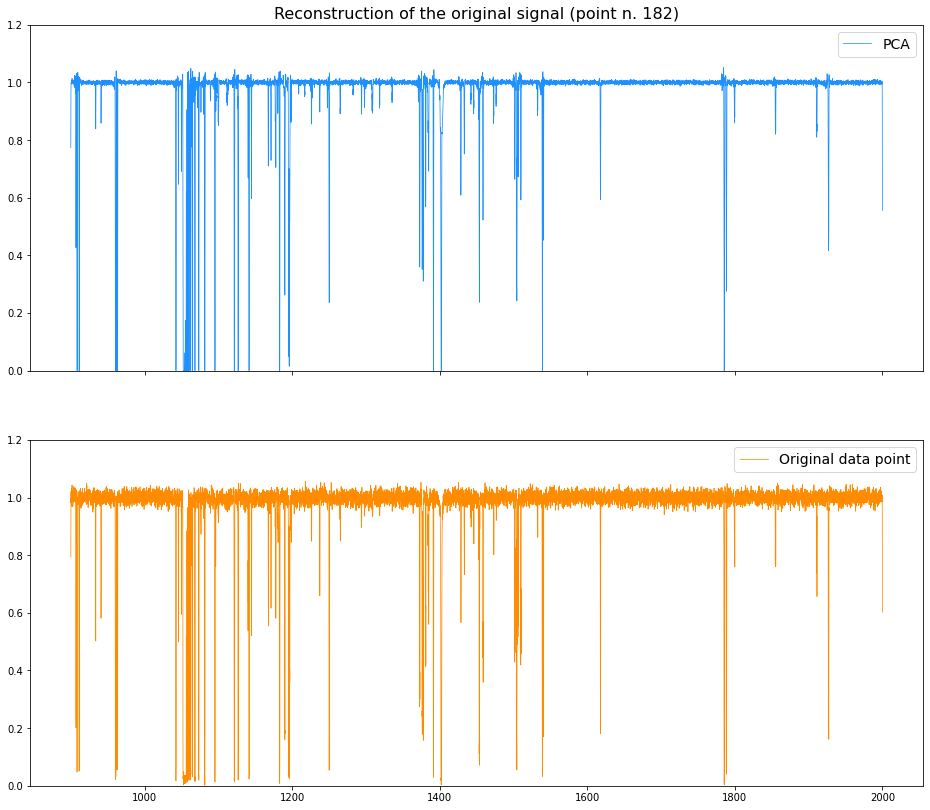

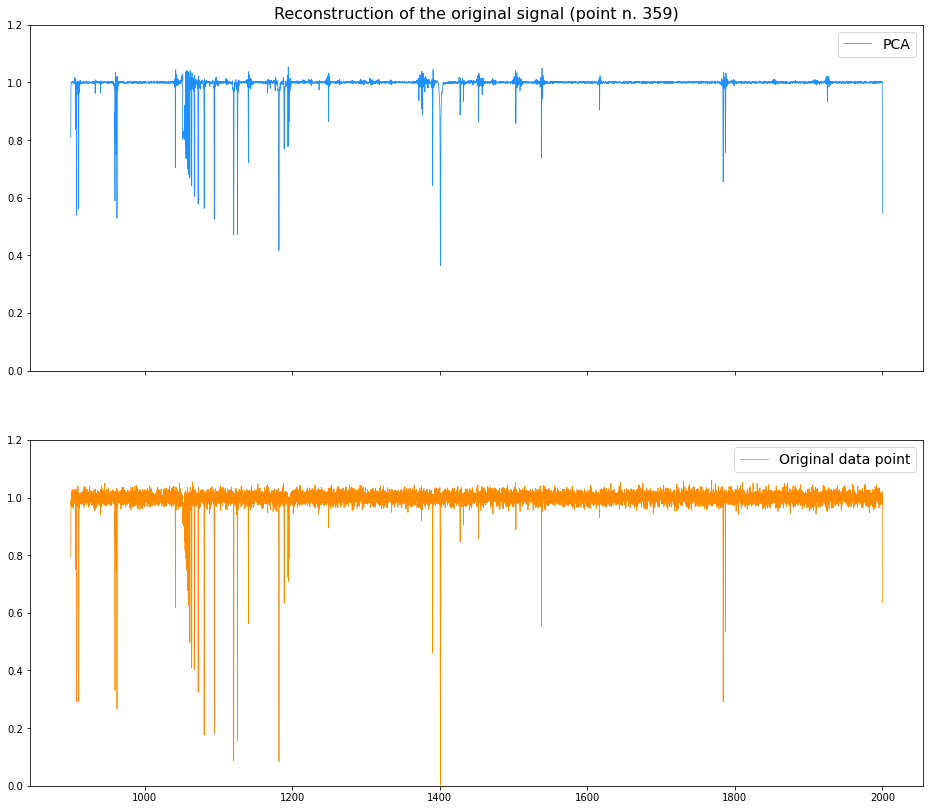

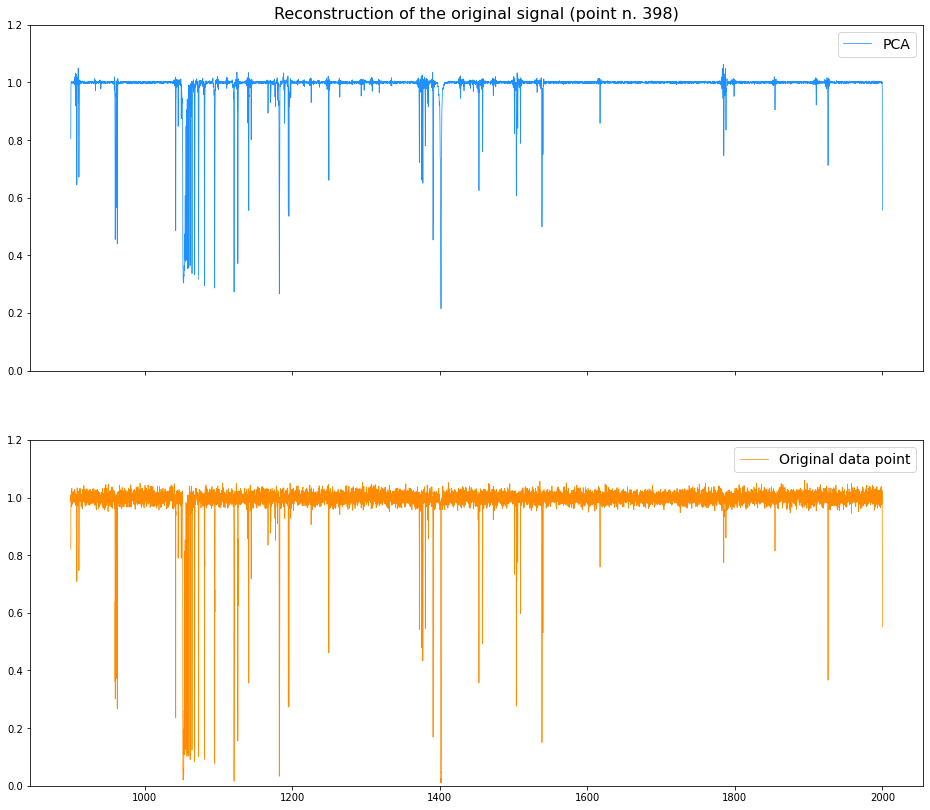

In [41]:
for random_number in random_number_list:

    # Recover PCA signal:
    recovered_signal = obs_projected_pca_2.to_numpy()[random_number,:]
    true_signal = val_df_pooled_rescaled[random_number,:]

    fig, ax = plt.subplots(2, 1, sharex = True, figsize = (16, 14))
    
    ax[0].plot(data_dict["wavelengths"], recovered_signal, label = "PCA", linewidth = 0.75, color = "dodgerblue")
    ax[0].legend(fontsize = 14)
    ax[0].set_ylim([0, 1.2])
    ax[1].plot(data_dict["wavelengths"], true_signal, label = "Original data point", linewidth = 0.75, color = "darkorange")
    ax[1].legend(fontsize = 14)
    ax[1].set_ylim([0, 1.2])
    ax[0].set_title("Reconstruction of the original signal (point n. " + str(random_number) + ")",
                   fontsize = (16));

##  A4: Error analysis

In [27]:
trim = True

val_projected_pca, val_original_space_proj_pca, loss_pca = calculate_reconstr_loss_pca_2(pca["object"], val_df_pooled, n_comp,
                             rescale = True, trim = trim,
                             mean = data_dict["parameters"]["mean"],
                             std = data_dict["parameters"]["std"])


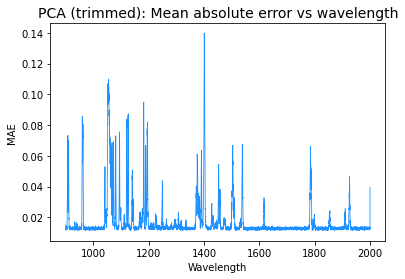

In [28]:
mean_abserror = np.abs(val_df_pooled_rescaled - val_original_space_proj_pca).mean(axis = 0)
std_abserror = np.abs(val_df_pooled_rescaled - val_original_space_proj_pca).std(axis = 0)

fig, ax = plt.subplots()
ax.plot(data_dict["wavelengths"], mean_abserror, color = "dodgerblue", linewidth = 0.8)
ax.set_xlabel("Wavelength")
ax.set_ylabel("MAE")
ax.set_title("PCA (trimmed): Mean absolute error vs wavelength", fontsize = 14);

Text(0.5, 0, 'Wavelength')

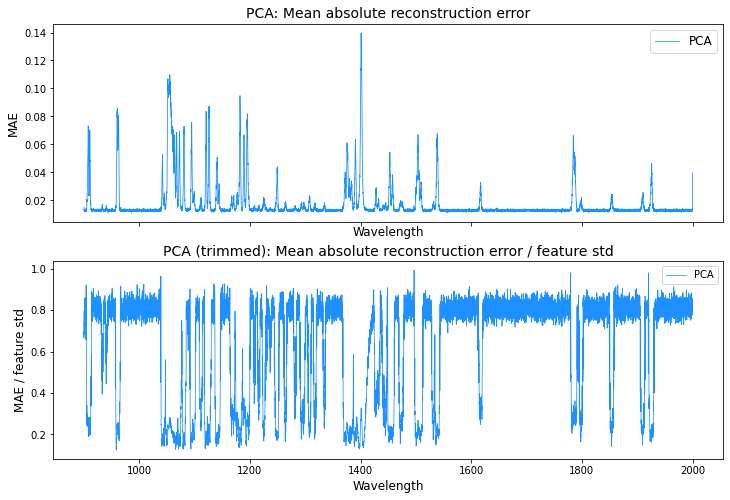

In [29]:
# fig, ax = plt.subplots(figsize = (10, 6))

fig, ax = plt.subplots( 2, 1, sharex = True, figsize = (12, 8) )
ax[0].plot(data_dict["wavelengths"], mean_abserror, color = "dodgerblue", linewidth = 0.8, label = "PCA")
ax[0].legend(fontsize = 12)
ax[0].set_xlabel("Wavelength", fontsize = 12)
ax[0].set_ylabel("MAE", fontsize = 12)
# ax[0].set_ylim([0, 0.2])
ax[0].set_title("PCA: Mean absolute reconstruction error", fontsize = 14)
# ax.plot(mean_abserror/mean_abserror.max())
ax[1].plot(data_dict["wavelengths"], mean_abserror/data_dict["parameters"]["std"], linewidth=0.75, color = "dodgerblue", label = "PCA" )
ax[1].legend()
ax[1].set_title("PCA (trimmed): Mean absolute reconstruction error / feature std", fontsize = 14)
ax[1].set_ylabel("MAE / feature std", fontsize = 12)
ax[1].set_xlabel("Wavelength", fontsize = 12)

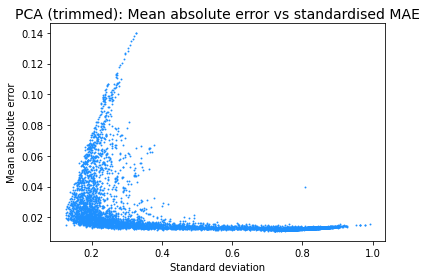

In [30]:
fig, ax = plt.subplots()
ax.scatter( mean_abserror/data_dict["parameters"]["std"], mean_abserror, s = 0.8, c = "dodgerblue" )
ax.set_xlabel("Standard deviation")
ax.set_ylabel("Mean absolute error")
ax.set_title("PCA (trimmed): Mean absolute error vs standardised MAE", fontsize = 14);

## A5: Errors and physical data

In [33]:
# load physical data

phys_var_cols = ['virial_rad', 'stellar_rad', 'impact', 'mass', 'disc']
phys_val = pd.DataFrame(data_dict["y"]["val"])
phys_val.columns = phys_var_cols 
phys_val.drop("mass", axis = 1, inplace = True)

# phys_val[["virial_rad", "stellar_rad"]] = np.log10(phys_val[["virial_rad", "stellar_rad"]])
phys_val.head()

scaler_y = StandardScaler()
phys_val_std = scaler_y.fit_transform(phys_val)

In [34]:
pca_errors = val_df_pooled_rescaled - val_original_space_proj_pca

In [35]:
pca_errors_means = pca_errors.mean(axis = 1)
pca_errors_means_std = (pca_errors_means - pca_errors_means.mean())/pca_errors_means.std() 

In [36]:
import statsmodels.api as sm
import numpy as np
duncan_prestige = sm.datasets.get_rdataset("Duncan", "carData")
Y = pca_errors_means_std
X = phys_val_std
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     25.62
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           4.93e-19
Time:                        16:15:20   Log-Likelihood:                -563.20
No. Observations:                 430   AIC:                             1136.
Df Residuals:                     425   BIC:                             1157.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.77e-18      0.043   -1.1e-16      1.0

In [37]:
coefs_array = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
pvals_array = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))
rsquared_array = np.empty(shape = val_df_pooled_rescaled.shape[1])
std_array = np.empty(shape = (phys_val_std.shape[1] + 1, val_df_pooled_rescaled.shape[1]))

for feature_num in np.arange(0, val_df_pooled_rescaled.shape[1]):
    
    feature = pca_errors.iloc[:, feature_num]
    
    feature_std = ( feature - feature.mean() )/ feature.std()
    X = phys_val_std
    X = sm.add_constant(X)
    
    Y = feature_std
    model = sm.OLS(Y,X)
    results = model.fit()
    
    coefs_array[:, feature_num] = results.params
    pvals_array[:, feature_num] = results.pvalues
    std_array[:, feature_num] = results.bse
    rsquared_array[feature_num] = results.rsquared

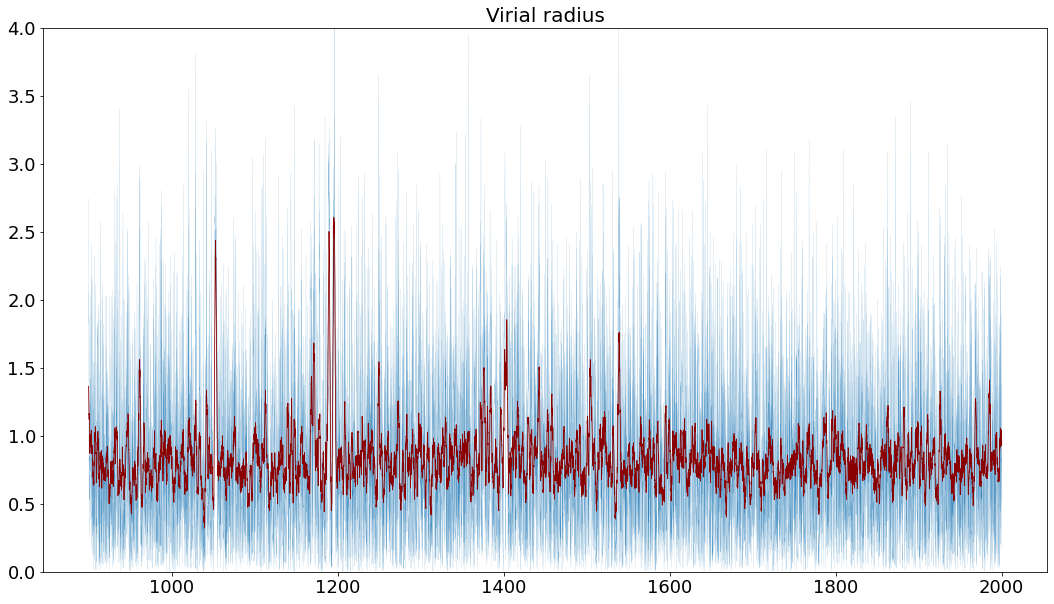

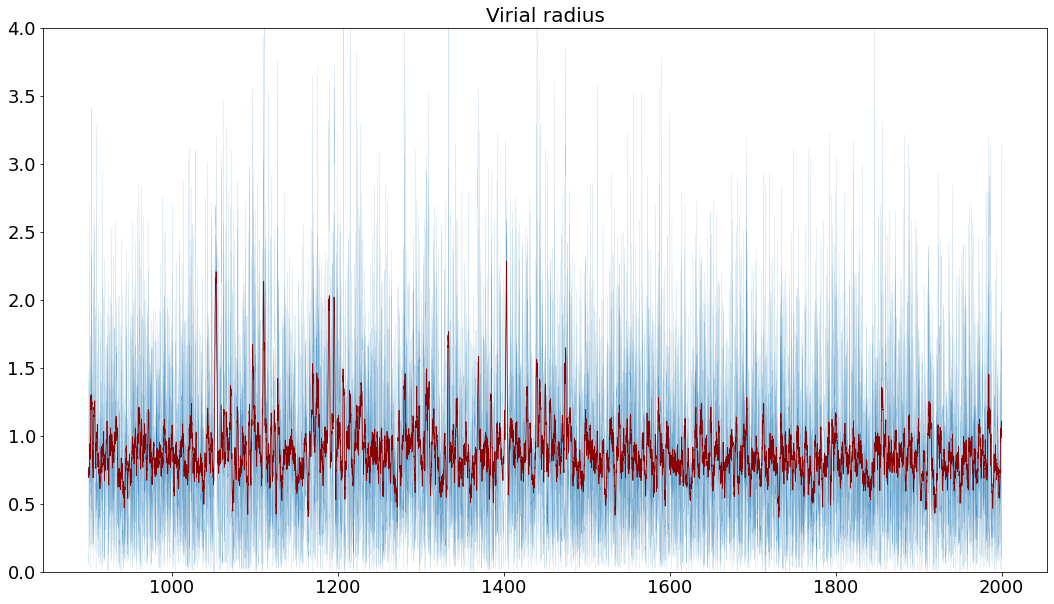

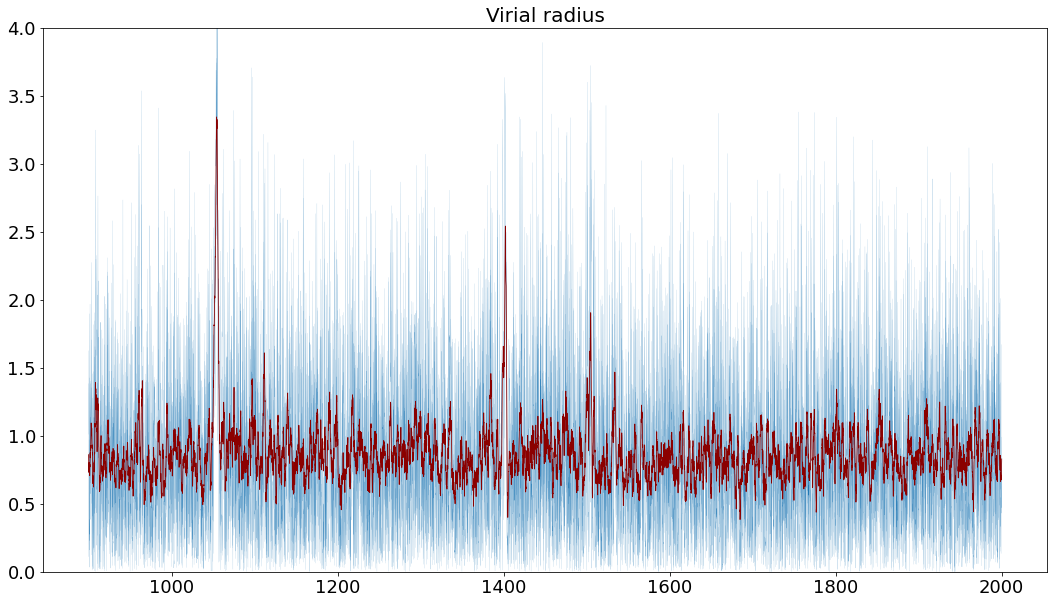

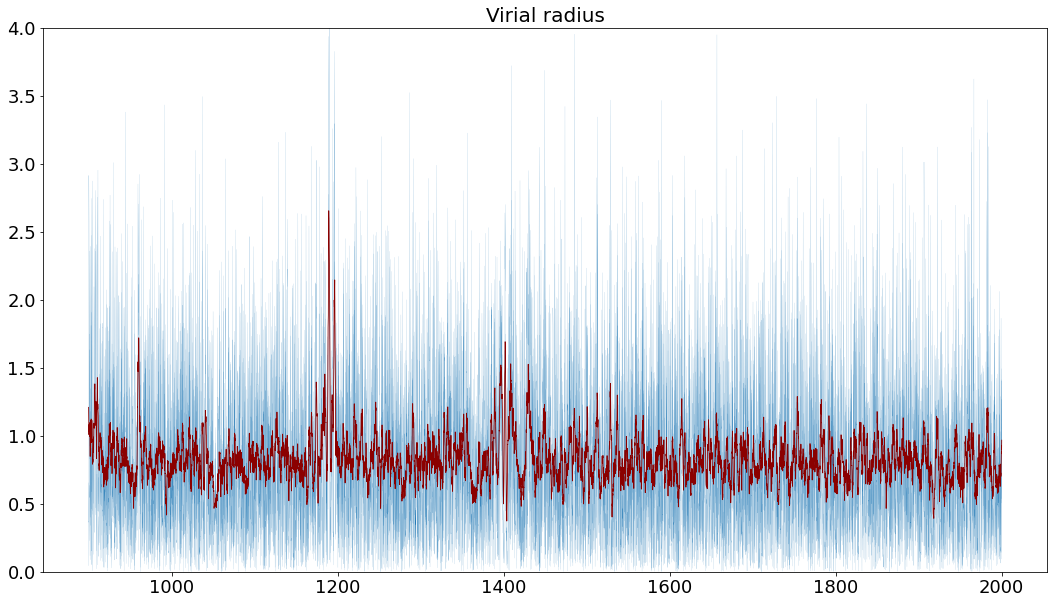

In [40]:
for i in np.arange(0, 4):

    plot_coefs_vs_wavelength( np.abs(coefs_array[i+1,:])/std_array[i+1,:], 20, 10, title = "Virial radius", 
                             xticks =data_dict["wavelengths"],
                        color_ma = "darkred", y_lim = [0, 4]) 